In [17]:
first_fiber_path = '/Users/fsp585/Desktop/GetherLabCode/Openfield/GqCoh1And2_OFT/First Test Round_guppy'

In [18]:
import sys
import os

# Store the original sys.path
original_sys_path = sys.path.copy()

# Temporarily add the path
sys.path.append(os.path.abspath("../../data"))

# Import the module
from guppy_loading import create_all_z_score_dfs

# Restore the original sys.path
sys.path = original_sys_path

In [19]:
guppy_path = '/Users/fsp585/Desktop/GetherLabCode/Openfield/GqCoh1And2_OFT/First Test Round_guppy'
all_z_score_dfs = create_all_z_score_dfs(guppy_path)

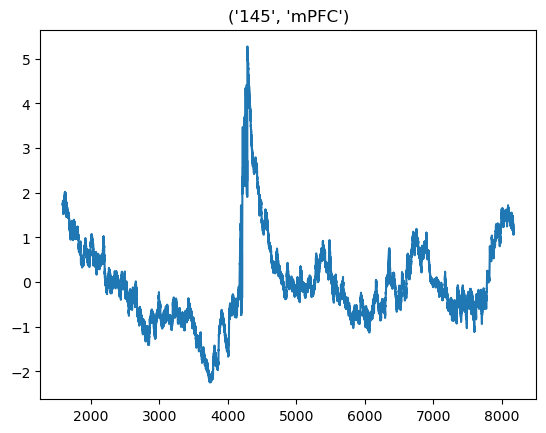

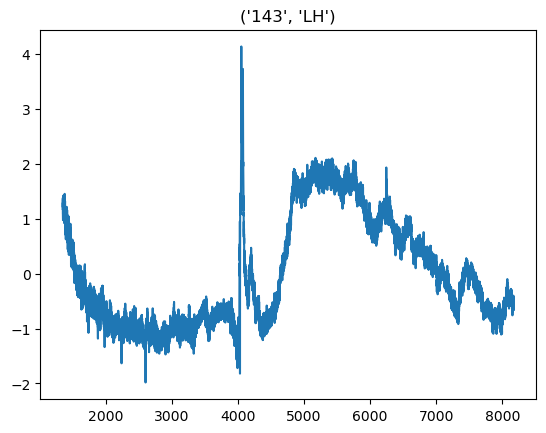

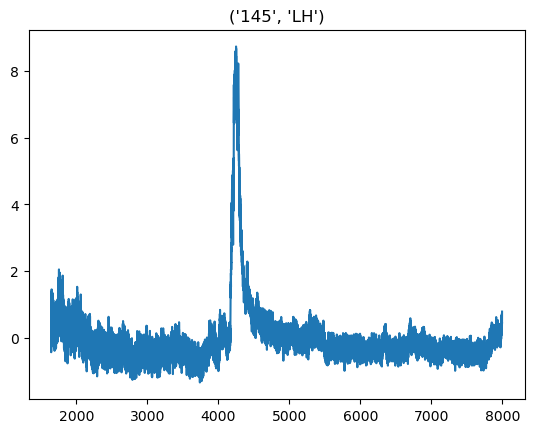

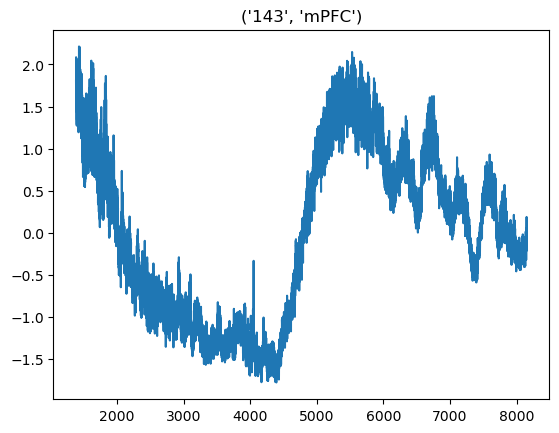

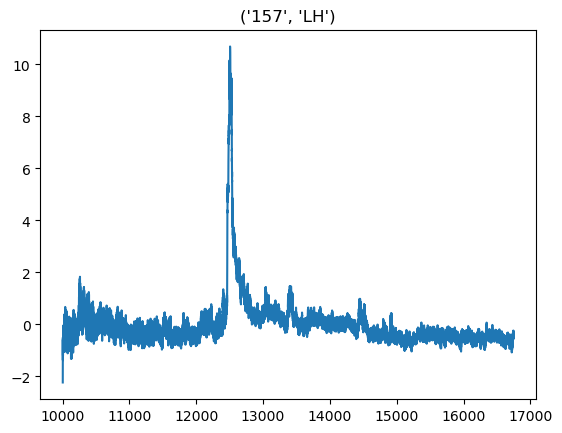

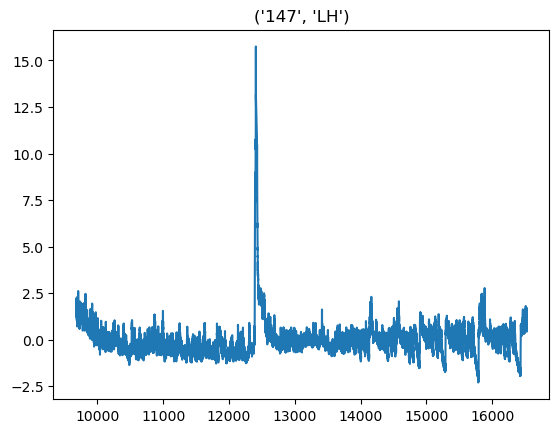

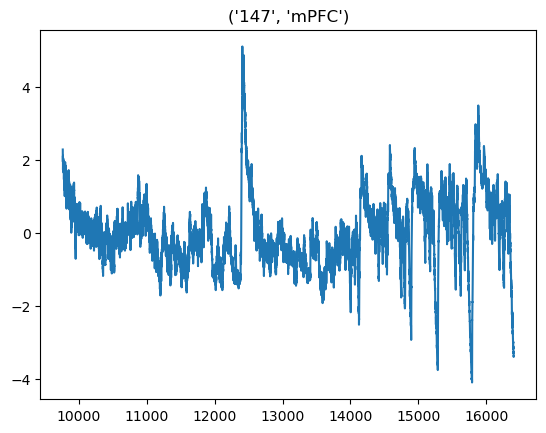

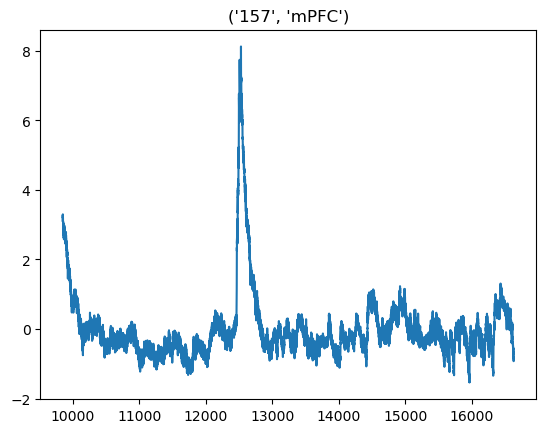

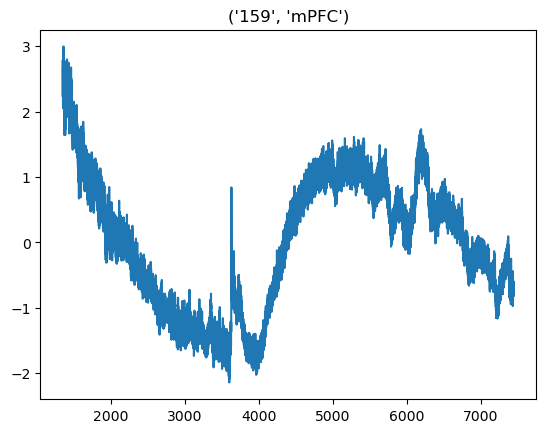

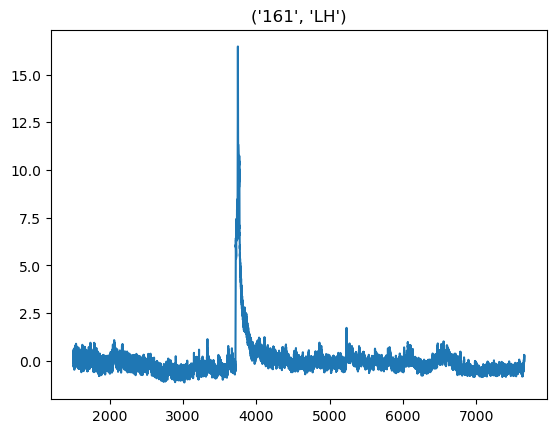

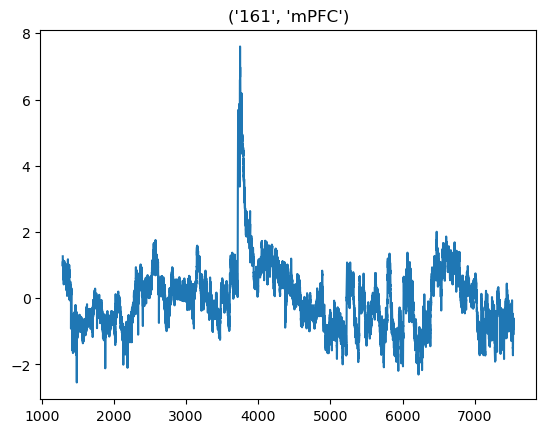

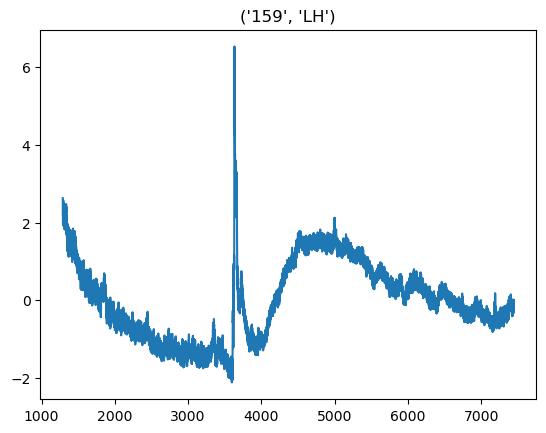

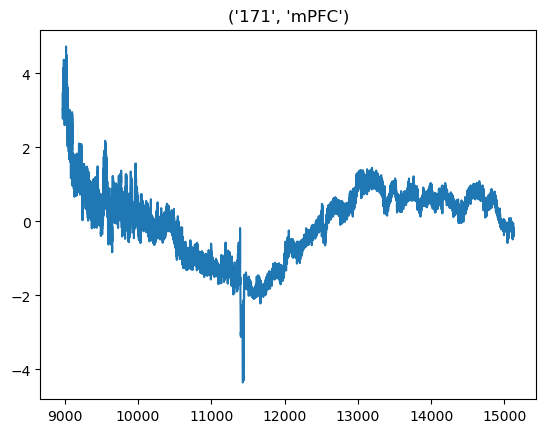

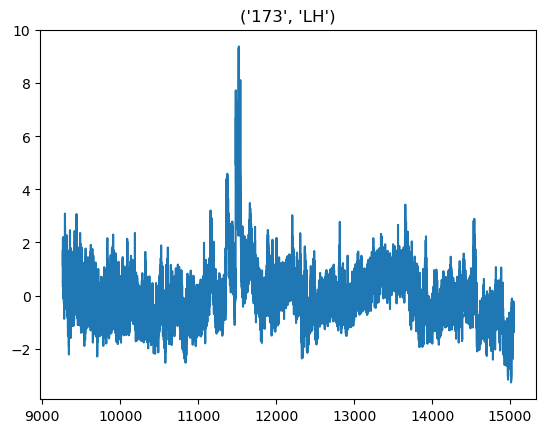

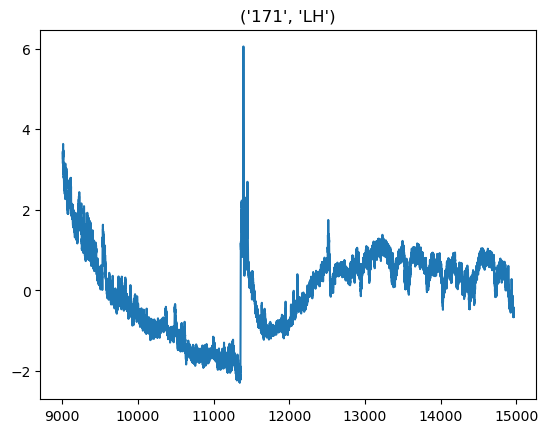

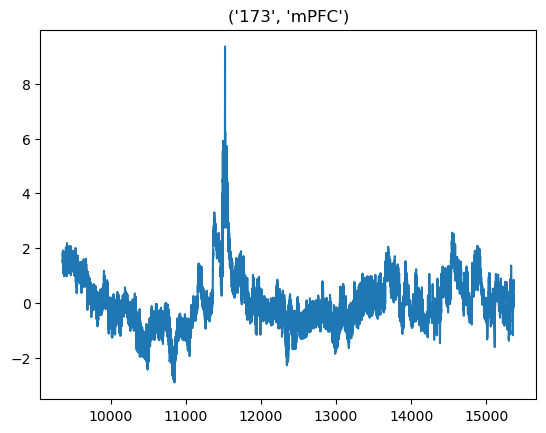

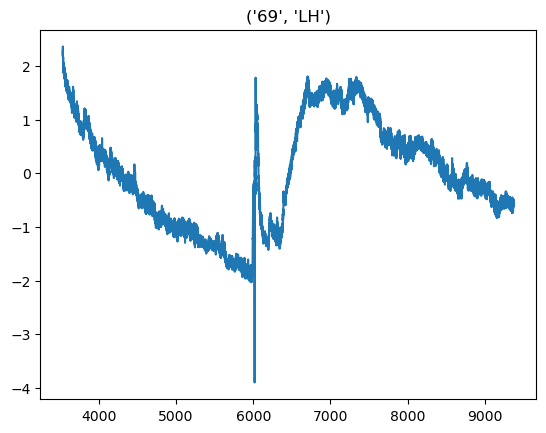

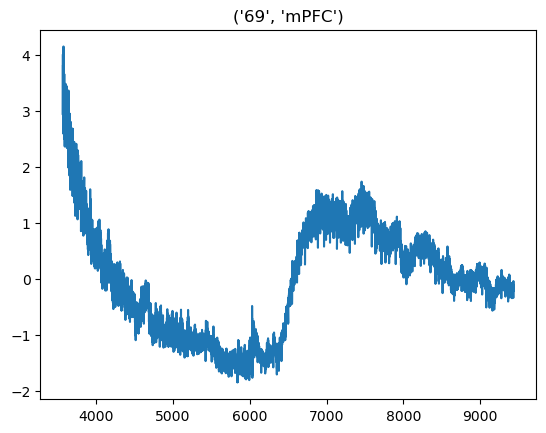

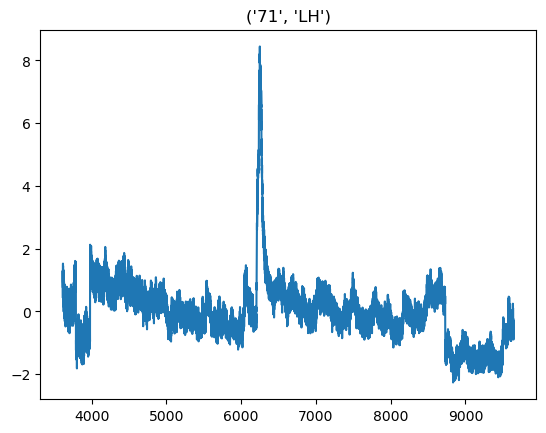

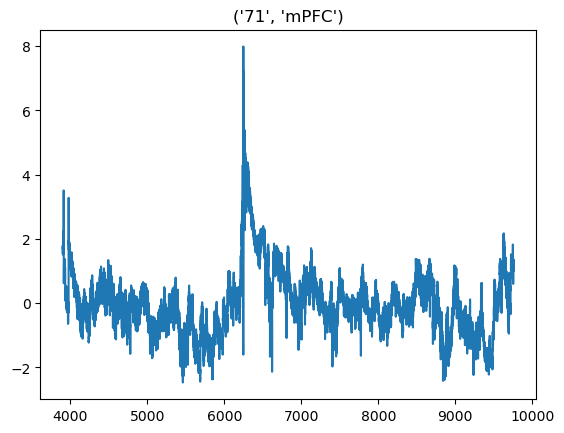

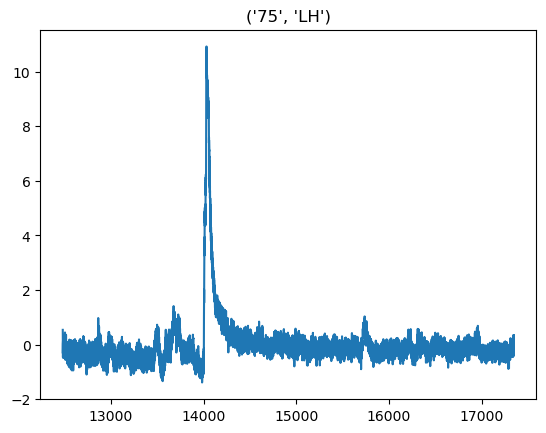

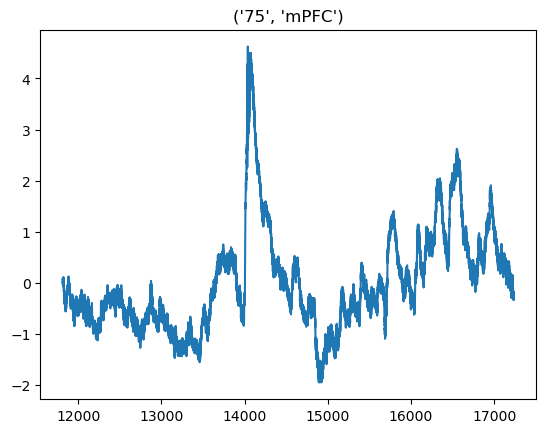

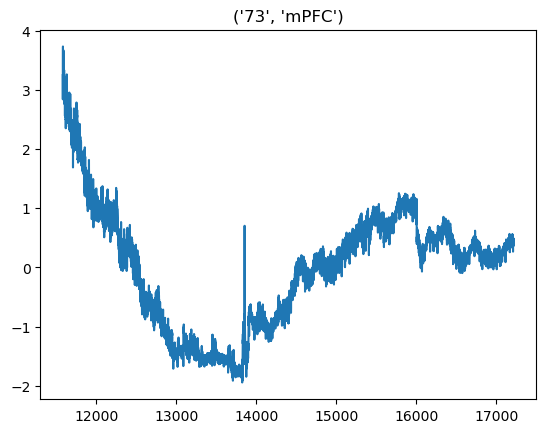

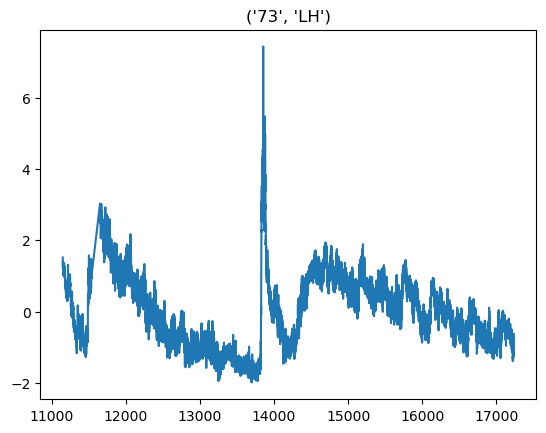

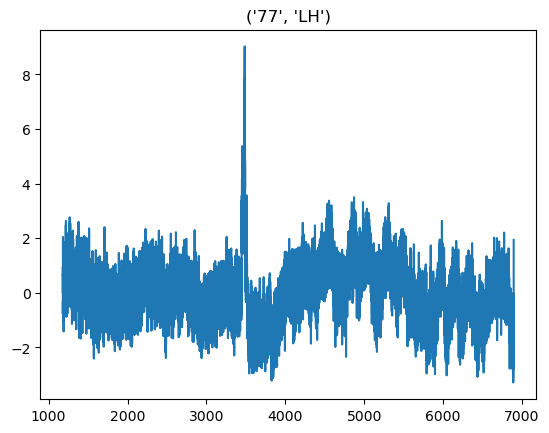

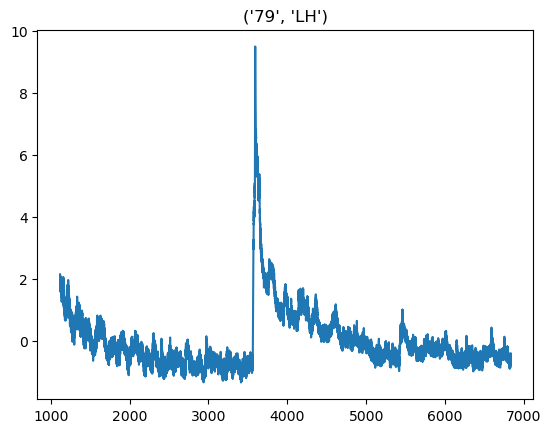

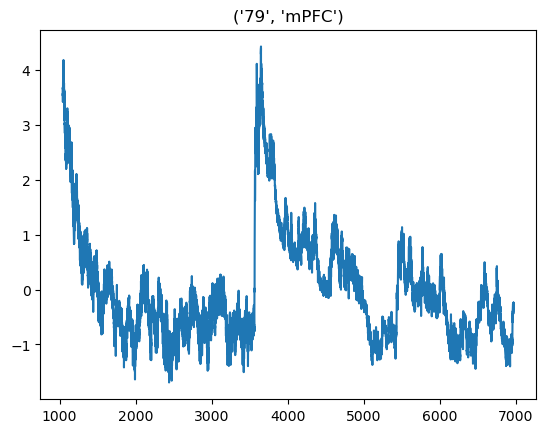

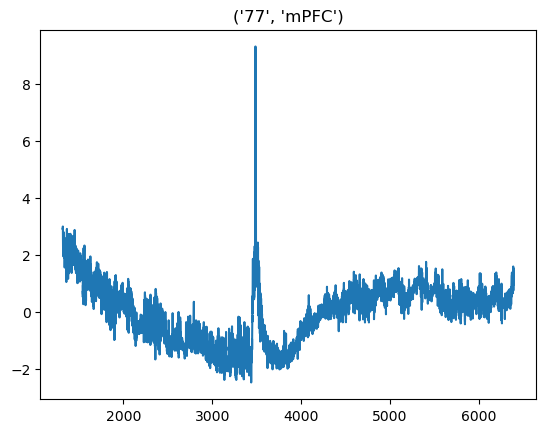

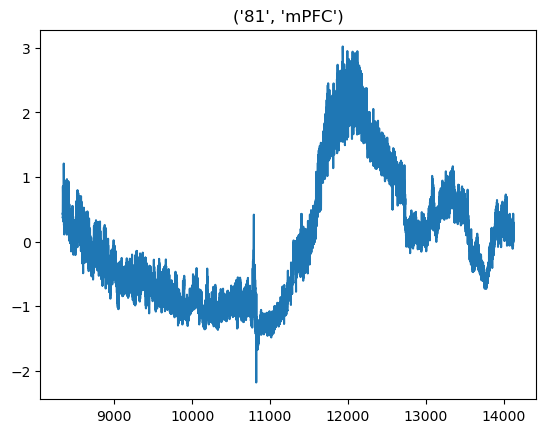

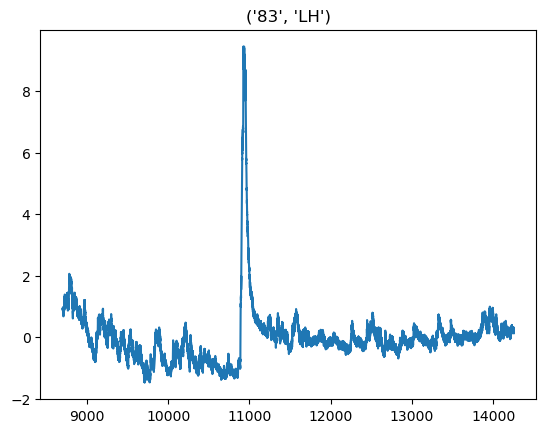

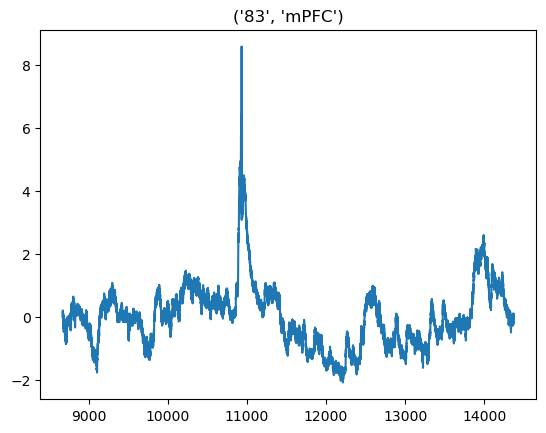

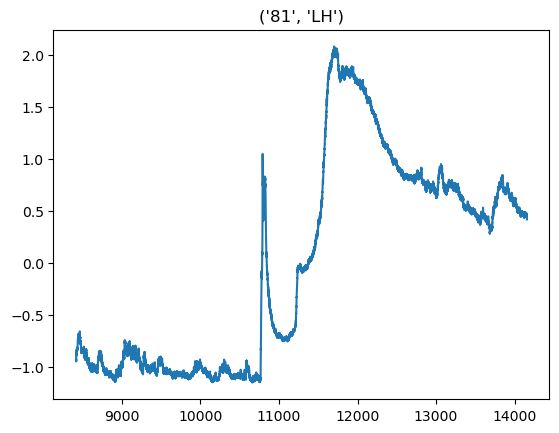

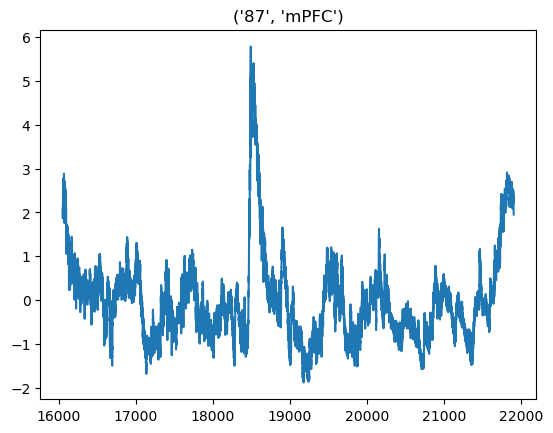

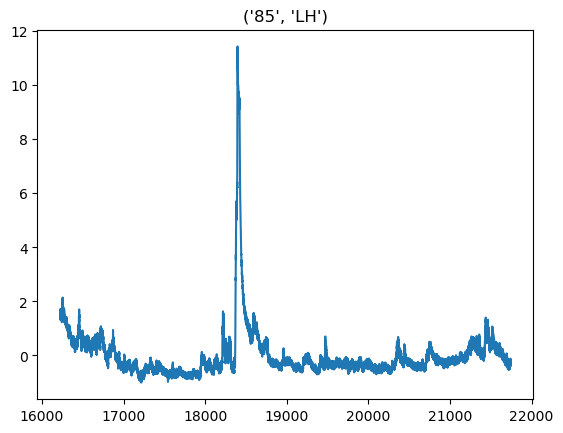

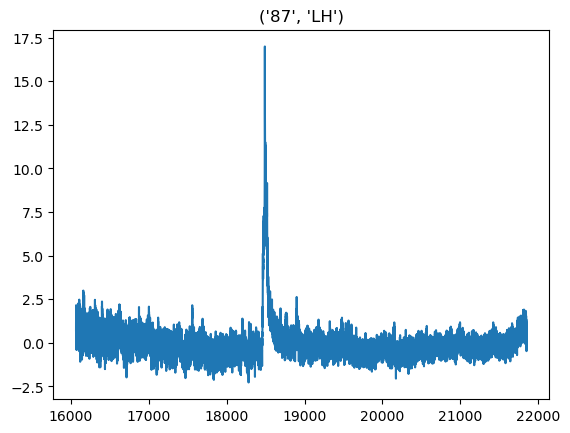

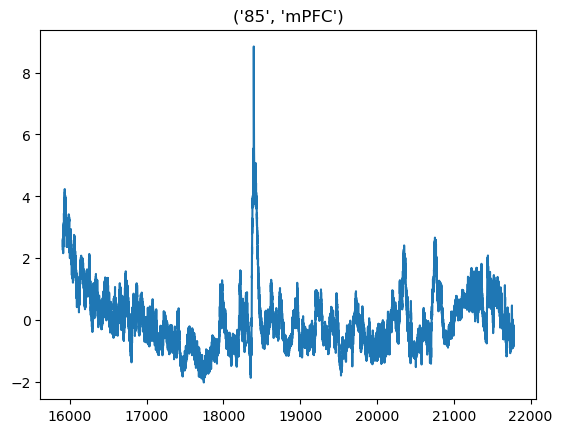

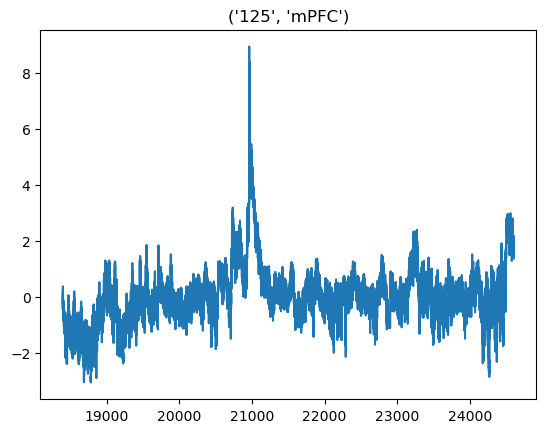

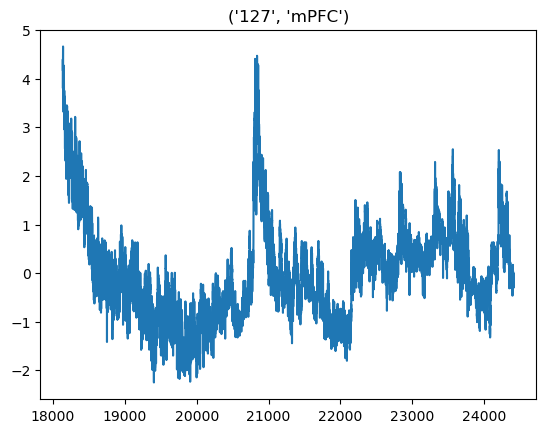

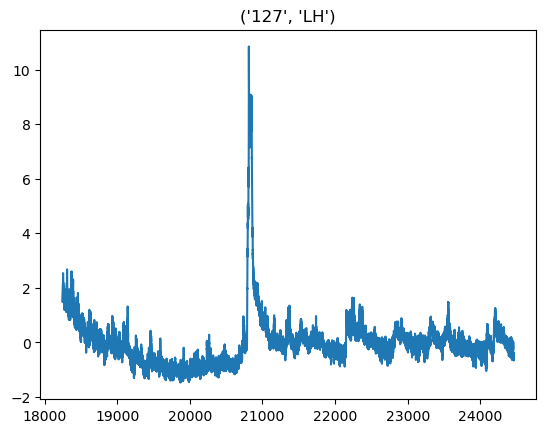

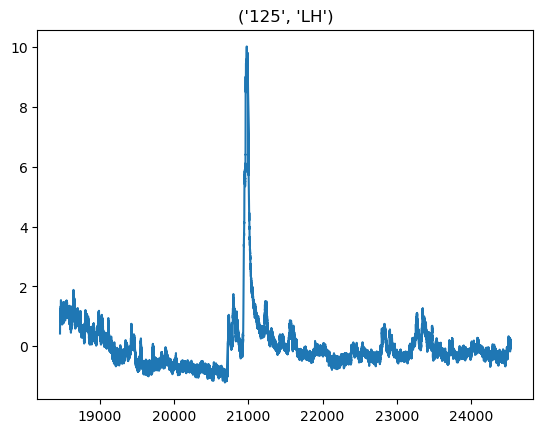

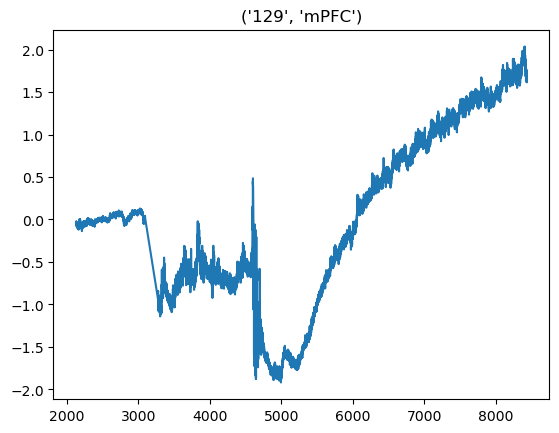

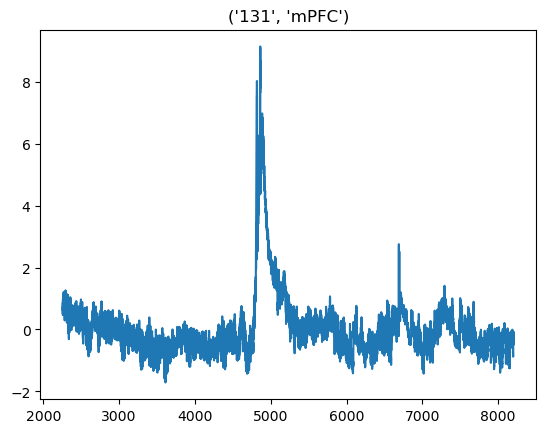

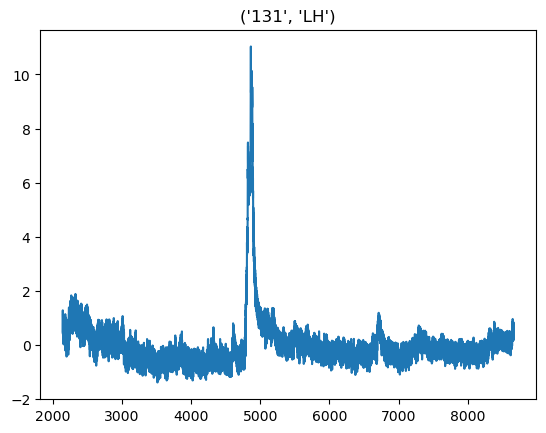

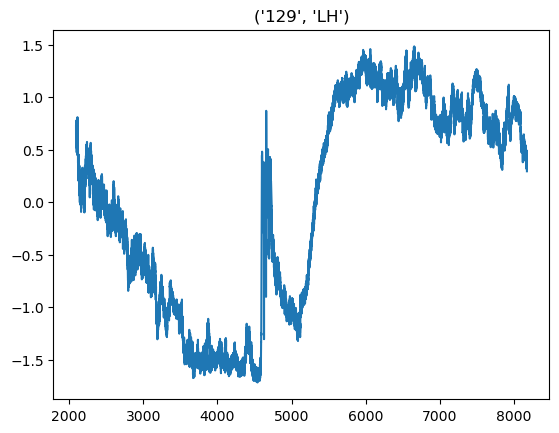

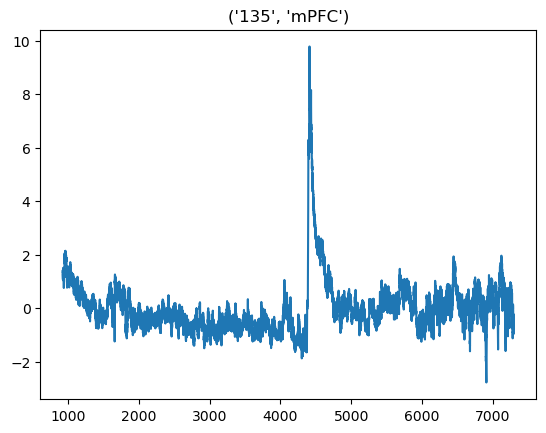

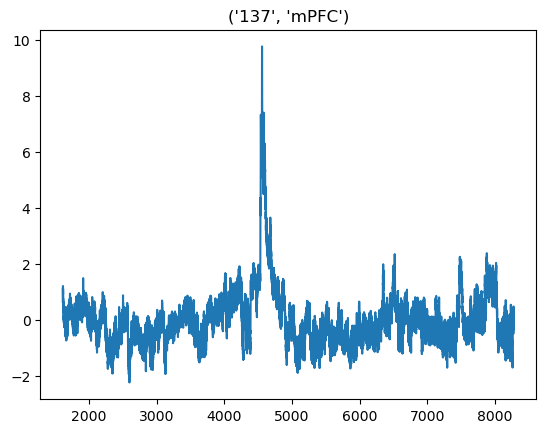

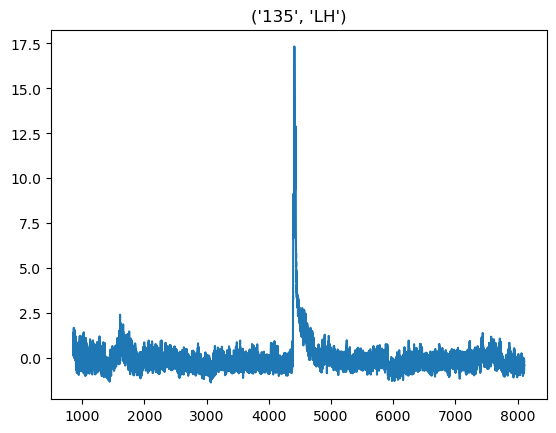

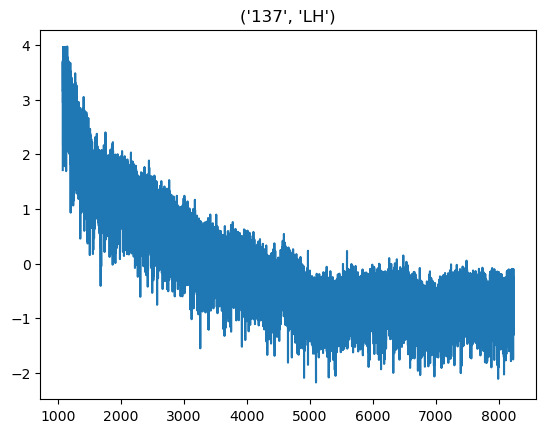

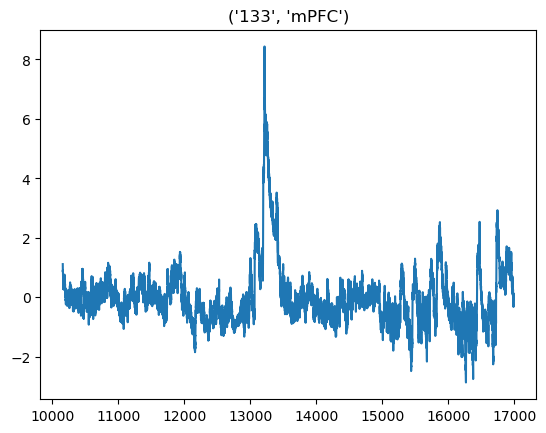

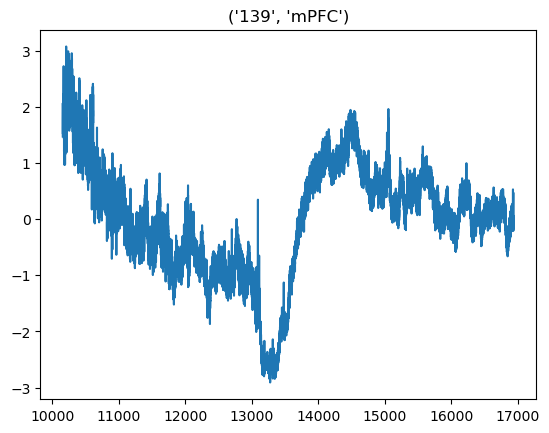

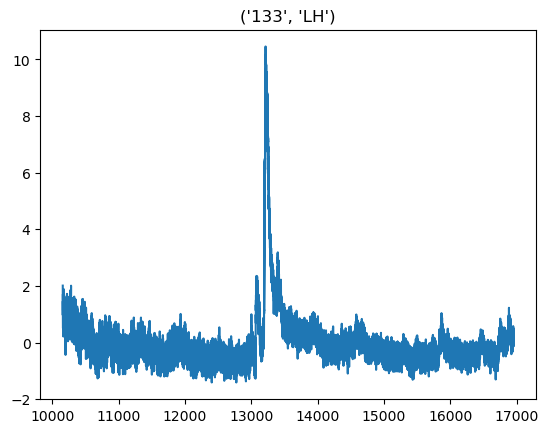

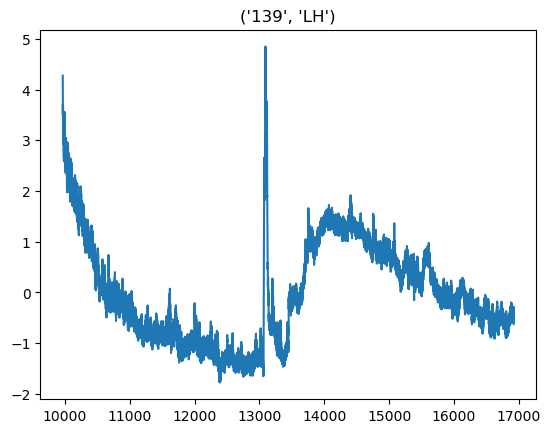

In [20]:
import matplotlib.pyplot as plt

for t, df in all_z_score_dfs.items():
    plt.title(str(t))
    plt.plot(df['timestamps'], df['data'])
    plt.show()

In [21]:
import pandas as pd
import glob
import os
import re

# Base directory for the data
base_dir = '/Users/fsp585/Desktop/GetherLabCode/Openfield/GqCoh1And2_OFT/First Test Round'

def get_mouse_directory(mouse_id):
    """Returns the directory containing data for a given mouse ID based on exact split matching."""
    matching_directory = None

    # Search through all directories that match the pattern 'T*' in the base directory
    for dir_path in glob.glob(os.path.join(base_dir, 'T*')):
        folder_name = os.path.basename(dir_path)  # Get only the folder name without the full path
        
        # Split the folder name to find mouse ID section
        try:
            ids_part = folder_name.split('_')[1].split('.')
            if mouse_id in ids_part:
                if matching_directory is not None:
                    print(f"Warning: Multiple directories match mouse ID {mouse_id}: {matching_directory} and {folder_name}")
                matching_directory = dir_path
        except IndexError:
            print(f"Warning: Directory name {folder_name} does not match expected format")

    if not matching_directory:
        print(f"No directory found for mouse ID {mouse_id}")
        
    return matching_directory

In [22]:
def load_csv_files(directory):
    """Loads the necessary CSV files from the specified directory."""
    # Load c415_bonsaiTS_*.csv
    c415_files = glob.glob(os.path.join(directory, 'c415_bonsaiTS_*.csv'))
    if not c415_files:
        print(f"No c415_bonsaiTS_*.csv file found in {directory}")
        return None, None
    c415_df = pd.read_csv(c415_files[0], sep='\s+')

    # Load BaslerCamTracking*.csv
    basler_cam_files = glob.glob(os.path.join(directory, 'BaslerTrack*.csv'))
    if not basler_cam_files:
        print(f"No BaslerCamTracking*.csv file found in {directory}")
        return None, None
    basler_cam_df = pd.read_csv(basler_cam_files[0], sep='\s+')
    return c415_df, basler_cam_df

In [25]:
def map_timestamps_to_frames(df, c415_df, basler_cam_df):
    """Maps timestamps in df to frame numbers in basler_cam_df through c415_df."""
    # Ensure both DataFrames are sorted by the timestamp columns for merge_asof to work correctly
    df = df.sort_values(by='timestamps')
    c415_df = c415_df.sort_values(by='FP3002_Timestamp_415')

    # Perform an asof merge, finding the closest FP3002_Timestamp_415 for each timestamp in df
    merged_df = pd.merge_asof(
        df, 
        c415_df[['FP3002_Timestamp_415', 'TimestampBonsai_415']],
        left_on='timestamps', 
        right_on='FP3002_Timestamp_415',
        direction='nearest',
        tolerance=0.5  # Tolerance in seconds (assuming timestamps are in seconds)
    )

    # Debugging information for mismatches
    if merged_df['TimestampBonsai_415'].isnull().any():
        print("Mismatch between df['timestamps'] and closest matches in c415_df['FP3002_Timestamp_415']")
        
        return None

    # Step 2: Align TimestampBonsai_415 with BonsaiTrackingTimestamp using merge_asof
    merged_df.sort_values('TimestampBonsai_415', inplace=True)
    basler_cam_df.sort_values('BonsaiTrackingTimestamp', inplace=True)
    
    aligned_df = pd.merge_asof(
        merged_df,
        basler_cam_df[['BonsaiTrackingTimestamp']],
        left_on='TimestampBonsai_415',
        right_on='BonsaiTrackingTimestamp',
        direction='nearest'
    )

    # Step 3: Retrieve frame numbers from index in basler_cam_df
    basler_cam_df = basler_cam_df.reset_index().rename(columns={'index': 'frame_number'})
    
    # Merge to add frame numbers to aligned_df
    final_df = pd.merge(
        aligned_df,
        basler_cam_df[['frame_number', 'BonsaiTrackingTimestamp']],
        on='BonsaiTrackingTimestamp',
        how='left'
    )

    # Add 'frame_number' to the original DataFrame
    df['frame_number'] = final_df['frame_number']
    return df

In [26]:
# Iterate over all entries in all_z_score_dfs
for (mouse_id, hemisphere), df in all_z_score_dfs.items():
    # Step 1: Get the correct directory for the mouse
    directory = get_mouse_directory(mouse_id)
    if not directory:
        continue  # Skip if directory not found

    # Step 2: Load CSV files
    c415_df, top_cam_df = load_csv_files(directory)
    if c415_df is None or top_cam_df is None:
        continue  # Skip if necessary files are missing

    # Step 3: Map timestamps to frame numbers
    df_with_frames = map_timestamps_to_frames(df, c415_df, top_cam_df)
    if df_with_frames is None:
        continue  # Skip if mapping failed

    # Step 4: Update the DataFrame in all_z_score_dfs with the frame numbers
    all_z_score_dfs[(mouse_id, hemisphere)] = df_with_frames

    print(f"Processed mouse ID {mouse_id}, hemisphere {hemisphere}")

# Now, all DataFrames in all_z_score_dfs have the 'frame_number' column added

Processed mouse ID 145, hemisphere mPFC
Processed mouse ID 143, hemisphere LH
Processed mouse ID 145, hemisphere LH
Processed mouse ID 143, hemisphere mPFC
Processed mouse ID 157, hemisphere LH
Processed mouse ID 147, hemisphere LH
Processed mouse ID 147, hemisphere mPFC
Processed mouse ID 157, hemisphere mPFC
Processed mouse ID 159, hemisphere mPFC
Processed mouse ID 161, hemisphere LH
Processed mouse ID 161, hemisphere mPFC
Processed mouse ID 159, hemisphere LH
Processed mouse ID 171, hemisphere mPFC
Processed mouse ID 173, hemisphere LH
Processed mouse ID 171, hemisphere LH
Processed mouse ID 173, hemisphere mPFC
Processed mouse ID 69, hemisphere LH
Processed mouse ID 69, hemisphere mPFC
Processed mouse ID 71, hemisphere LH
Processed mouse ID 71, hemisphere mPFC
Processed mouse ID 75, hemisphere LH
Processed mouse ID 75, hemisphere mPFC
Processed mouse ID 73, hemisphere mPFC
Processed mouse ID 73, hemisphere LH
Processed mouse ID 77, hemisphere LH
Processed mouse ID 79, hemisphere L

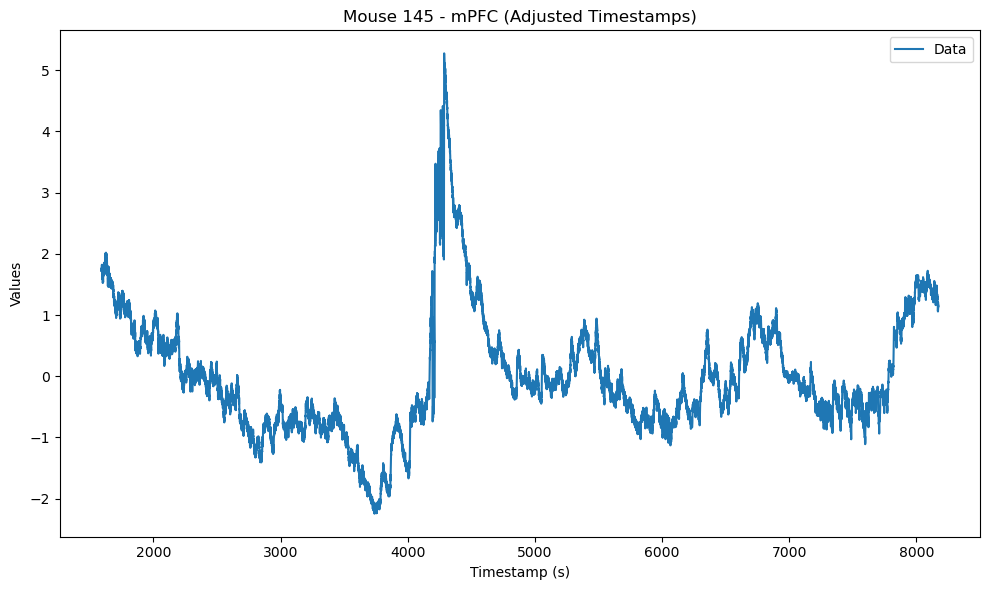

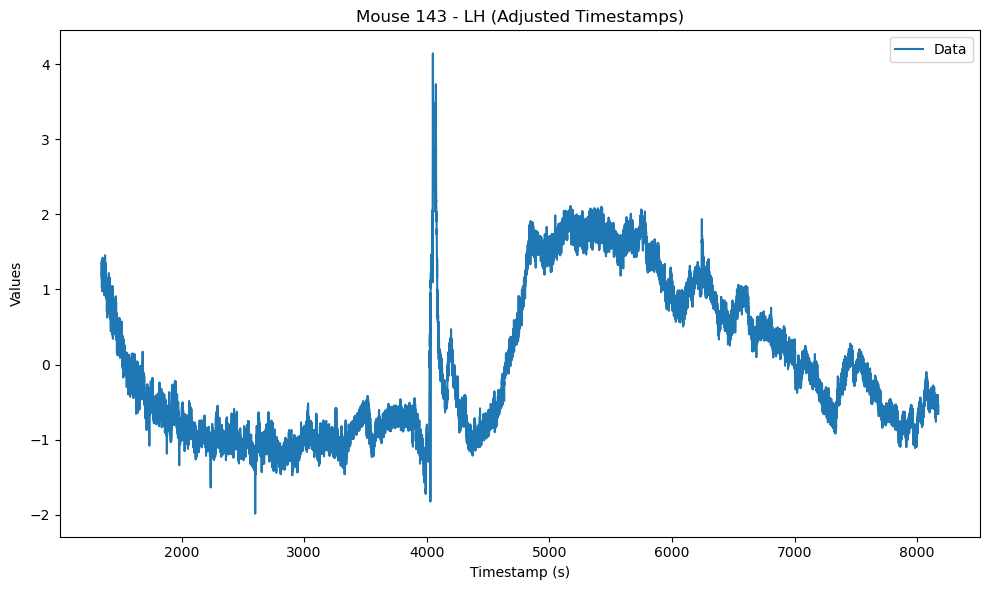

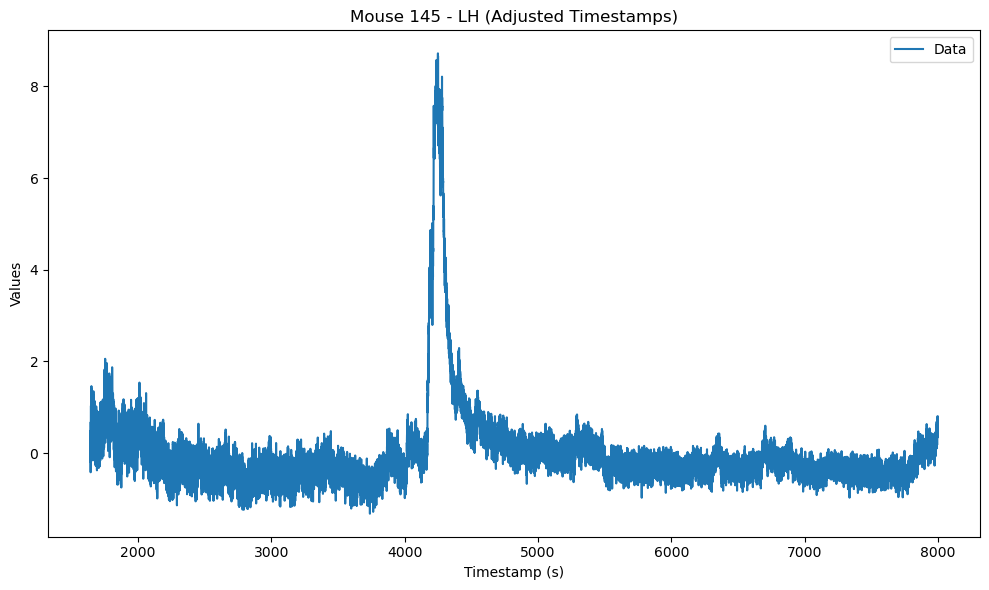

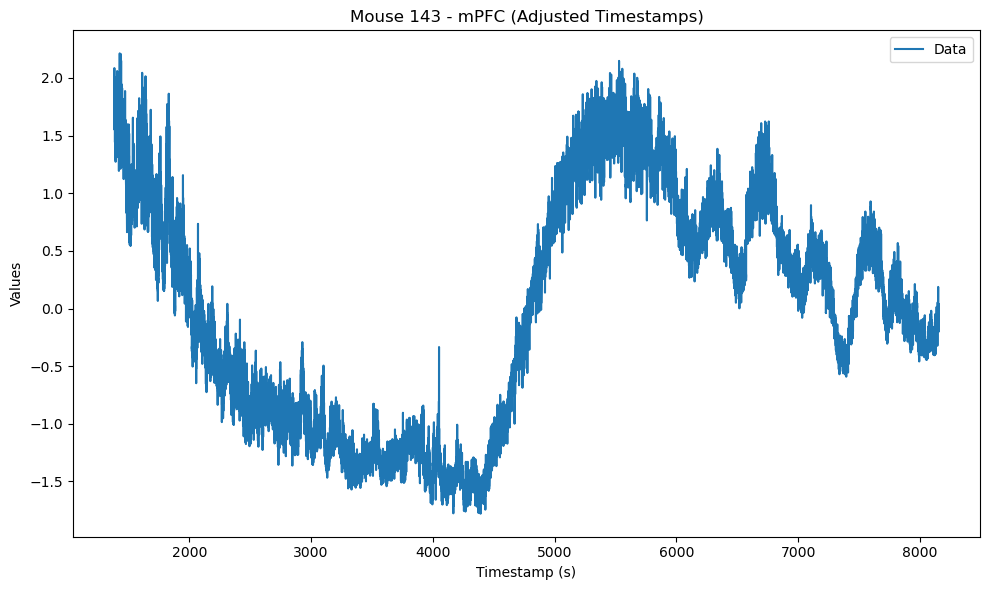

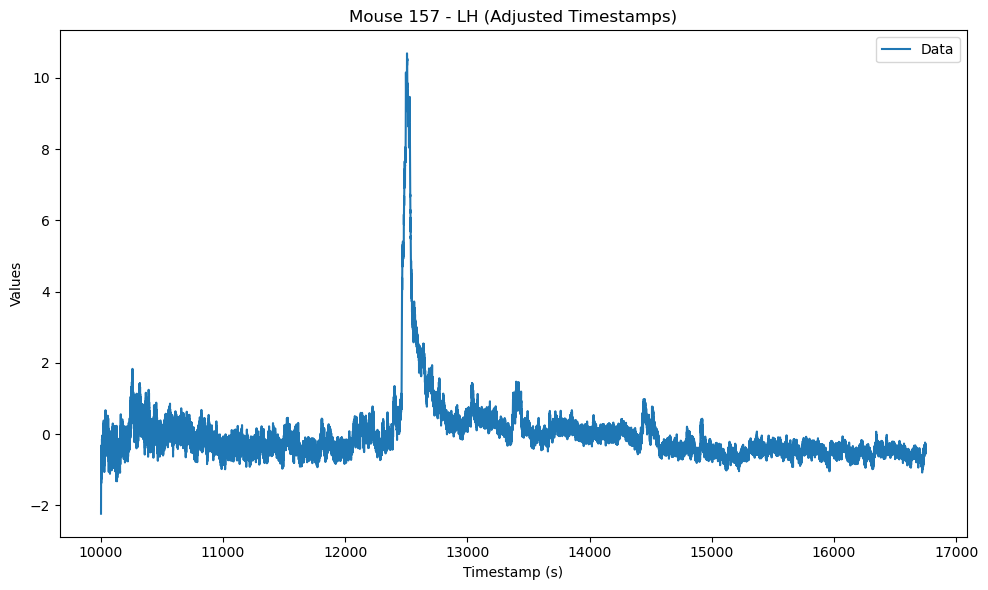

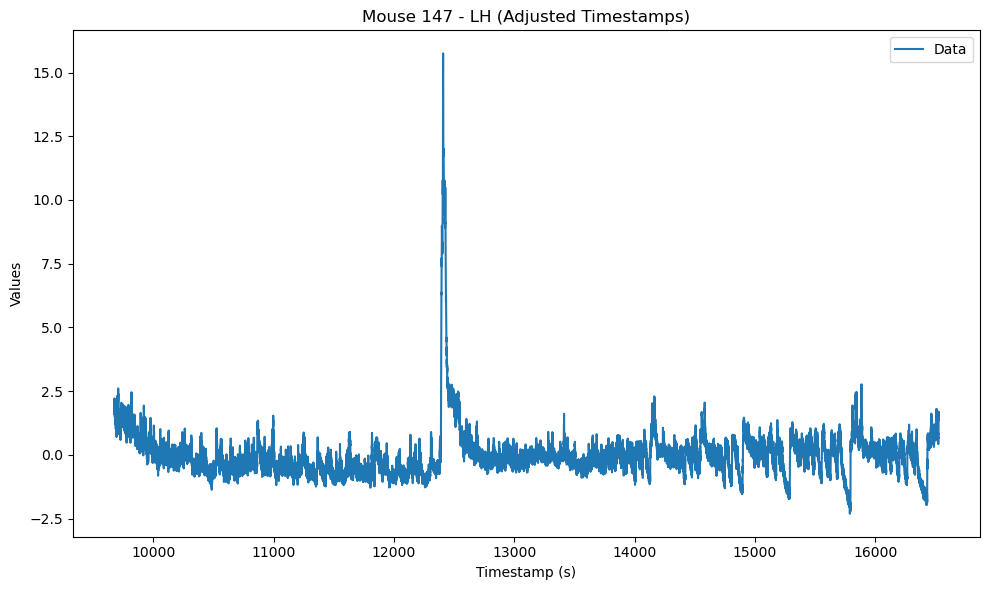

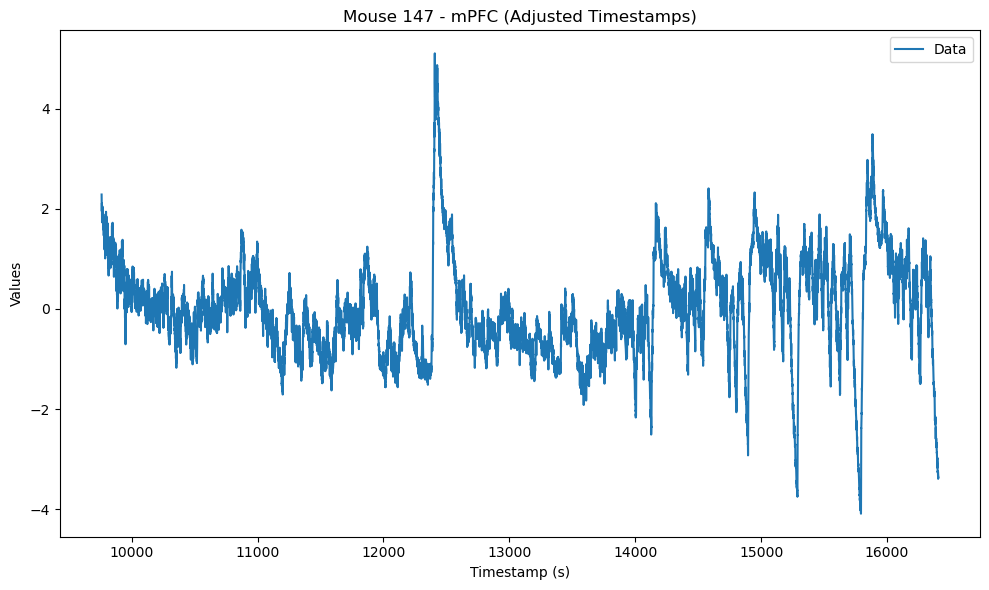

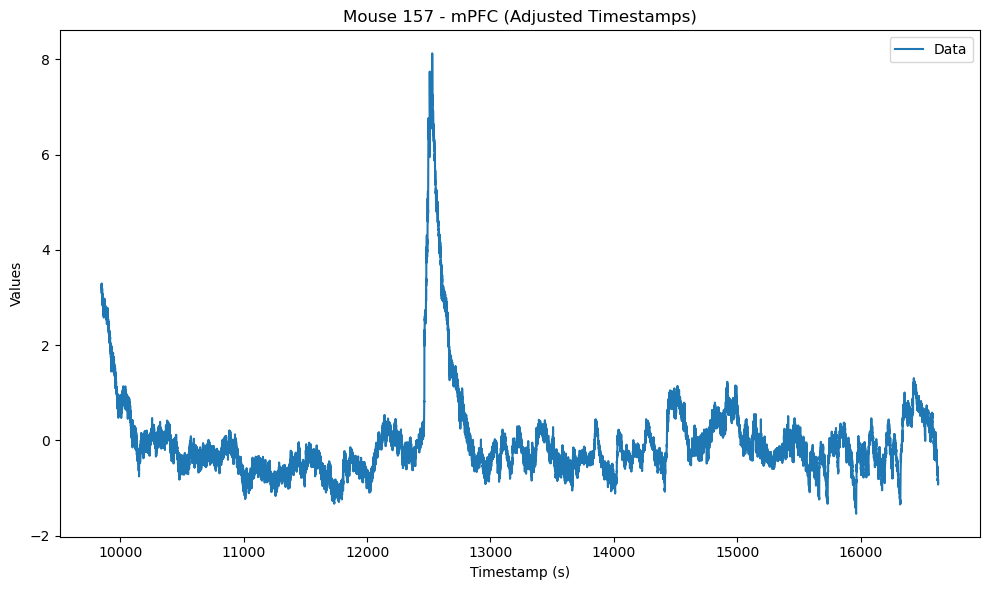

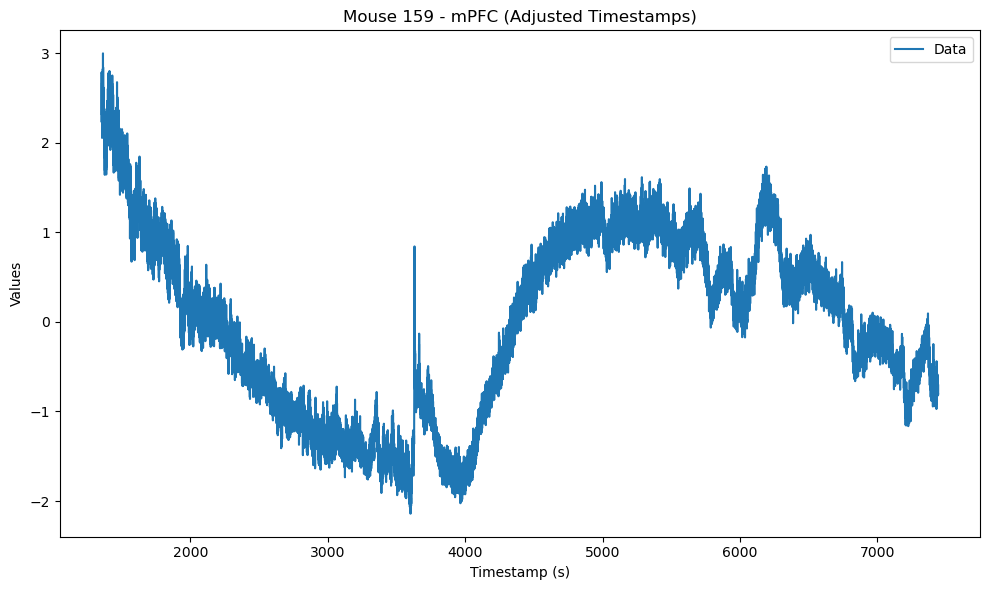

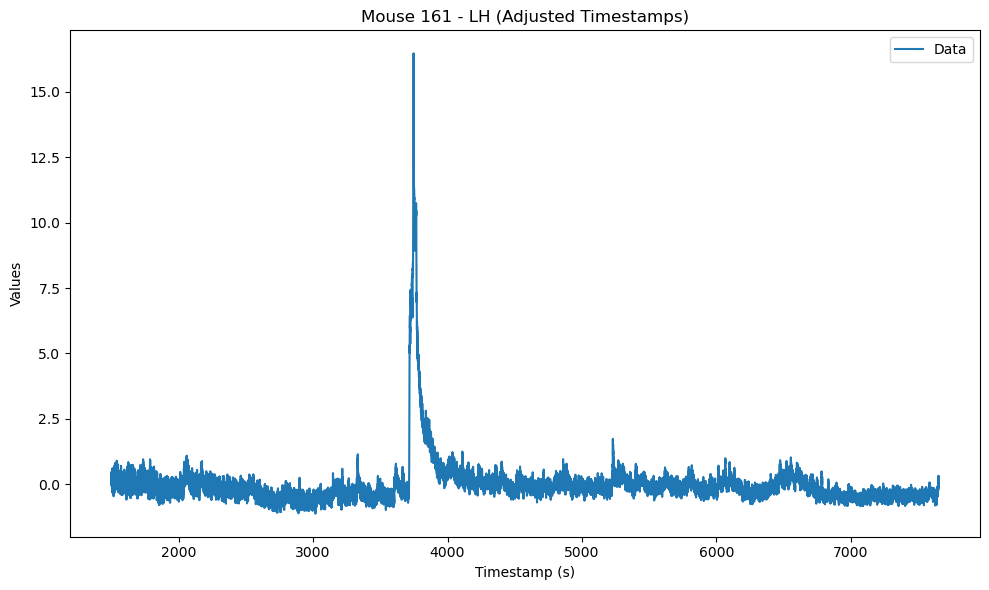

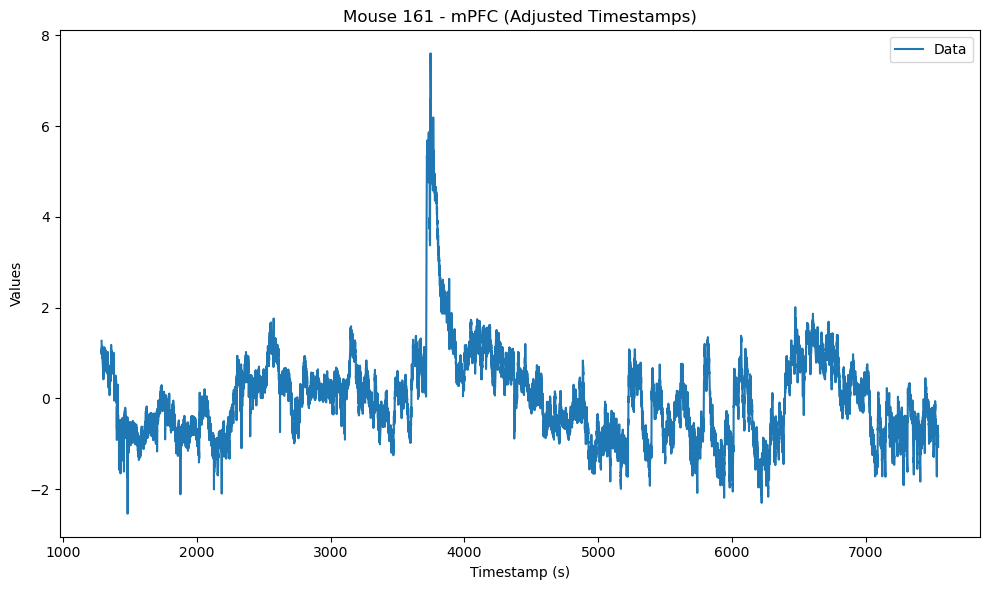

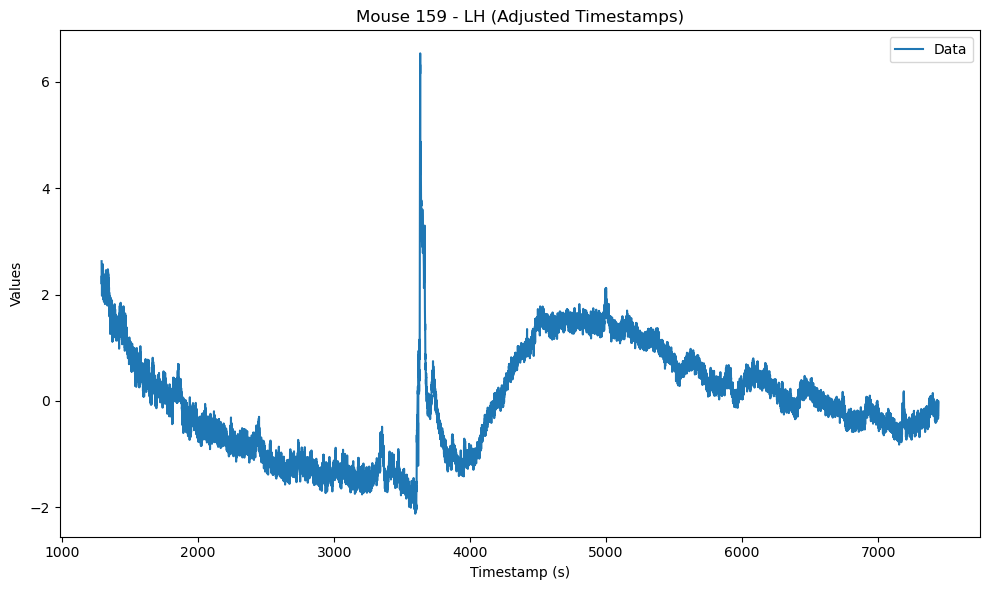

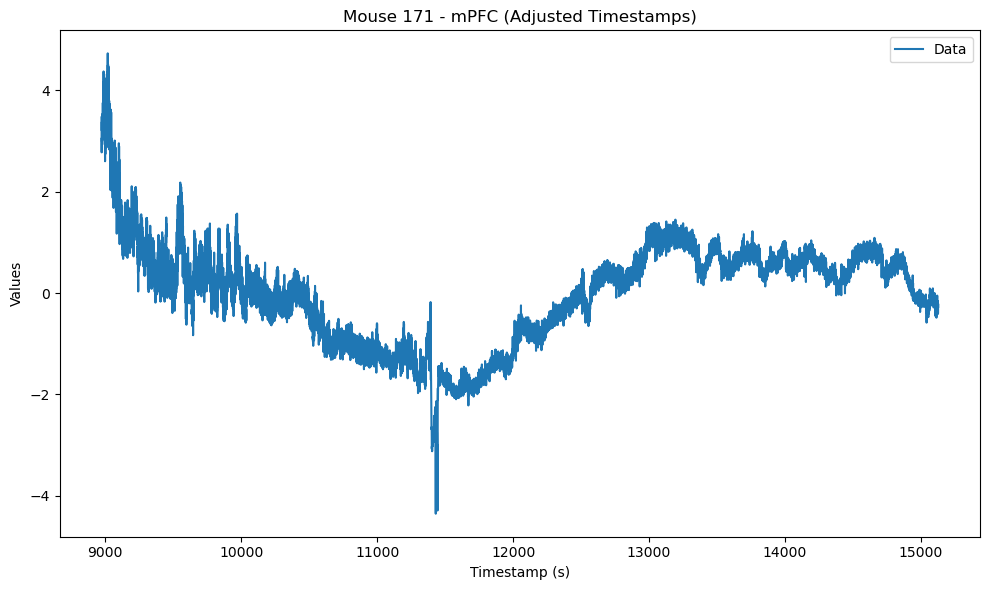

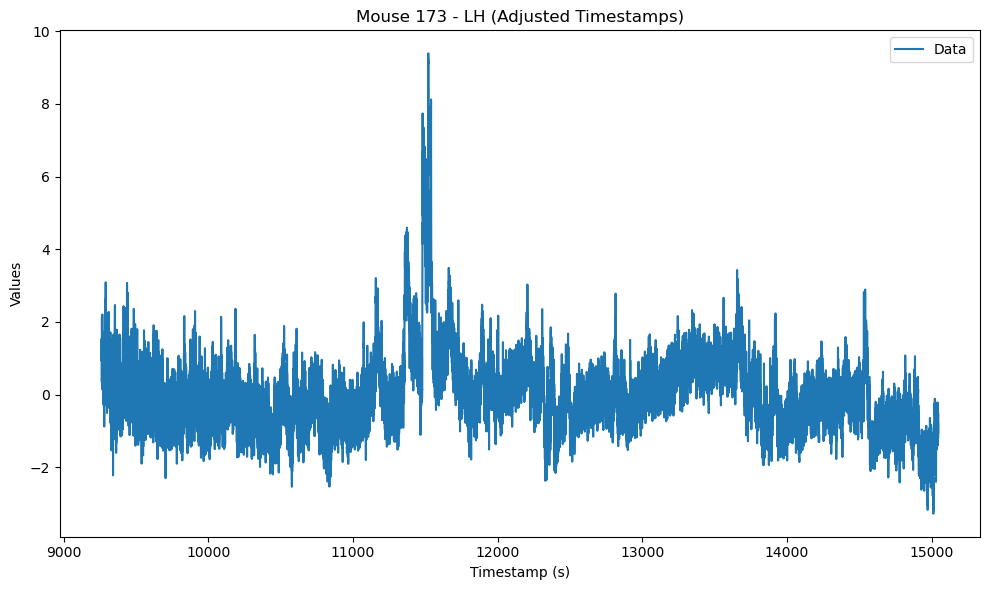

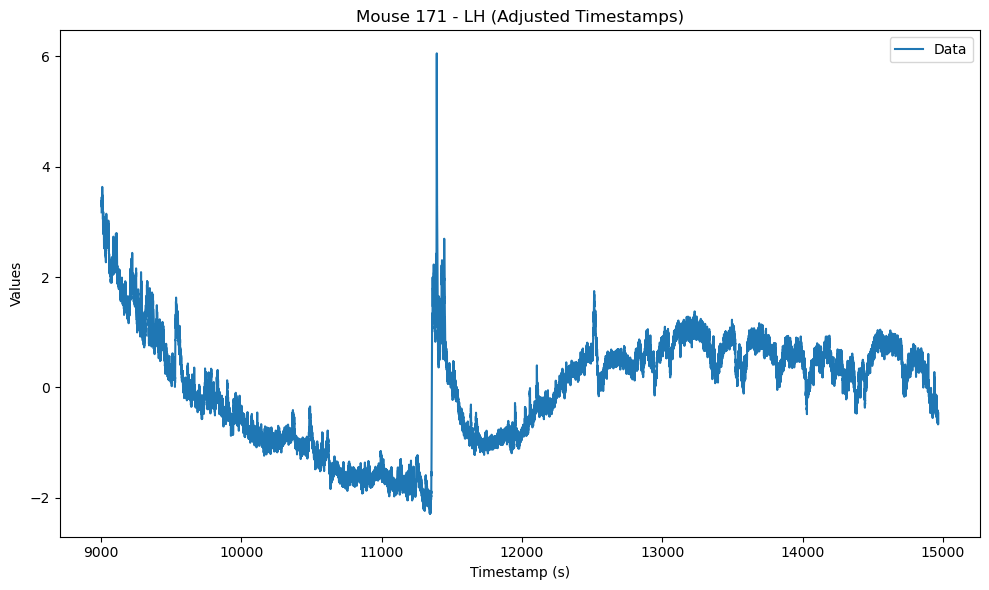

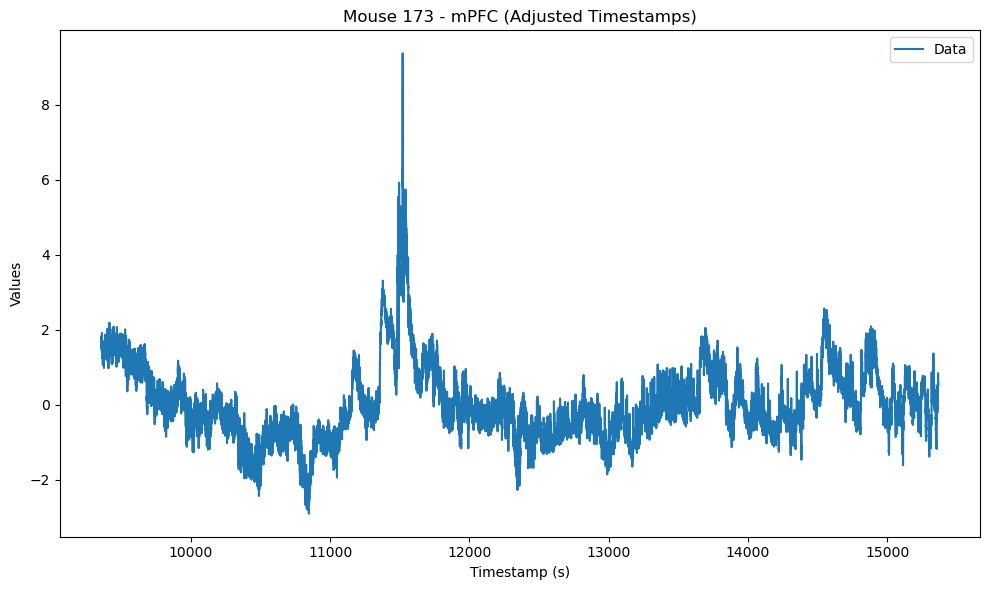

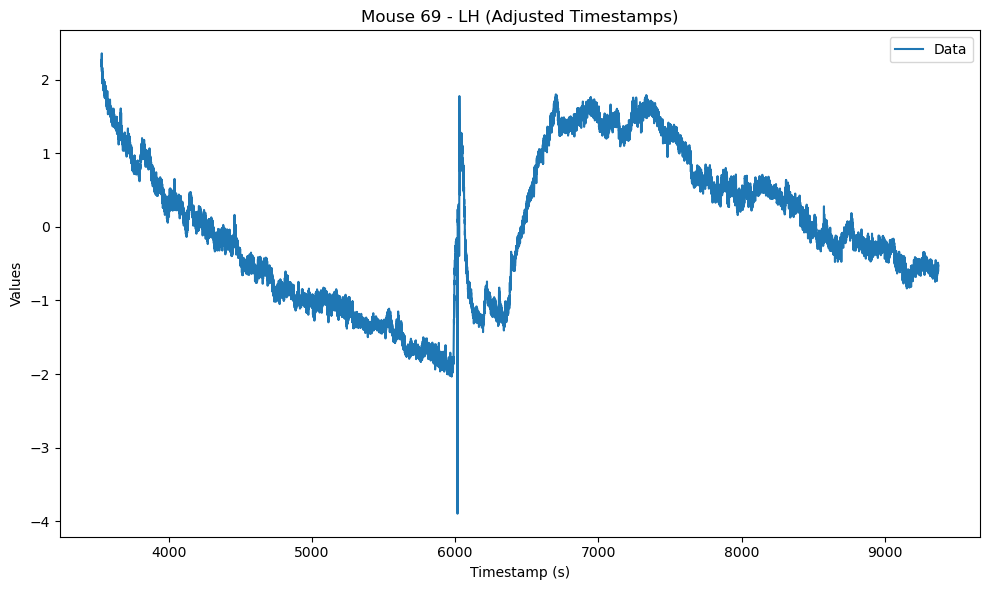

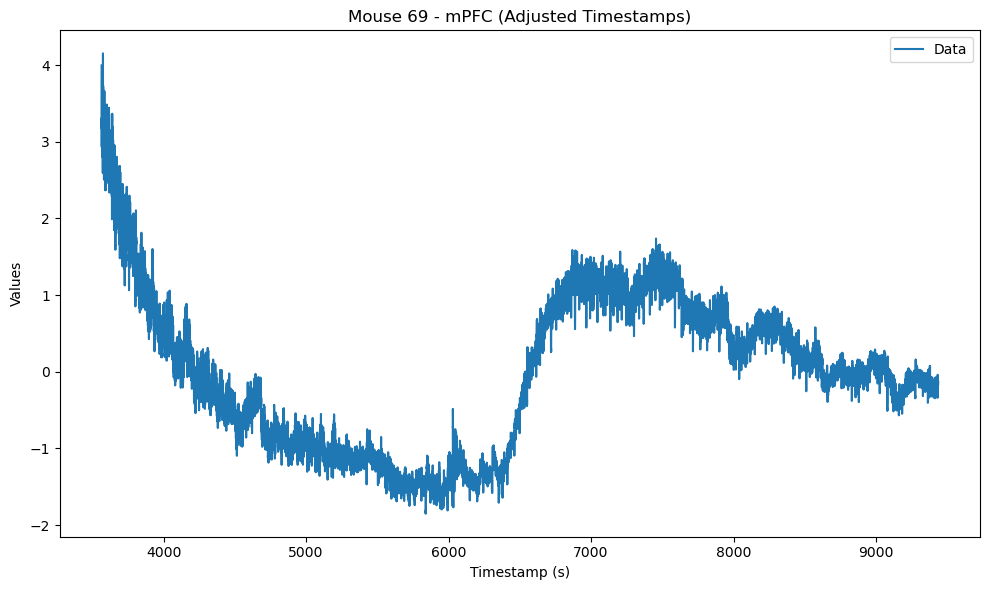

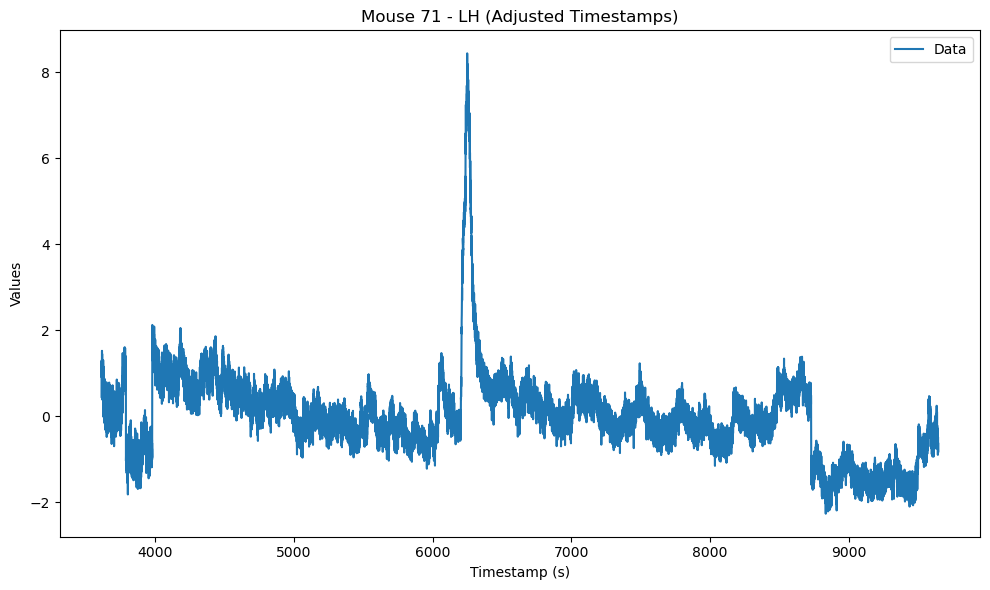

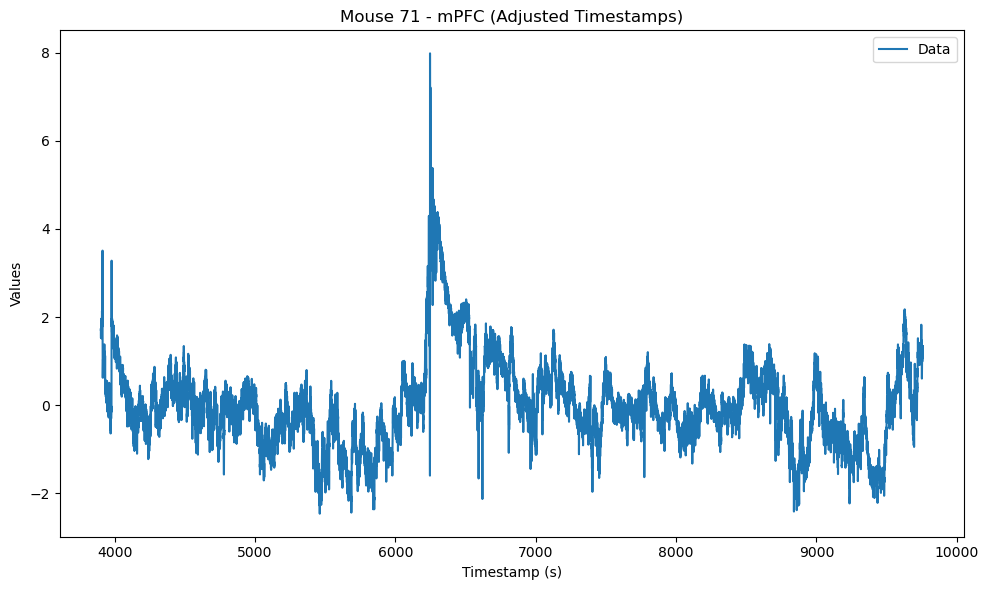

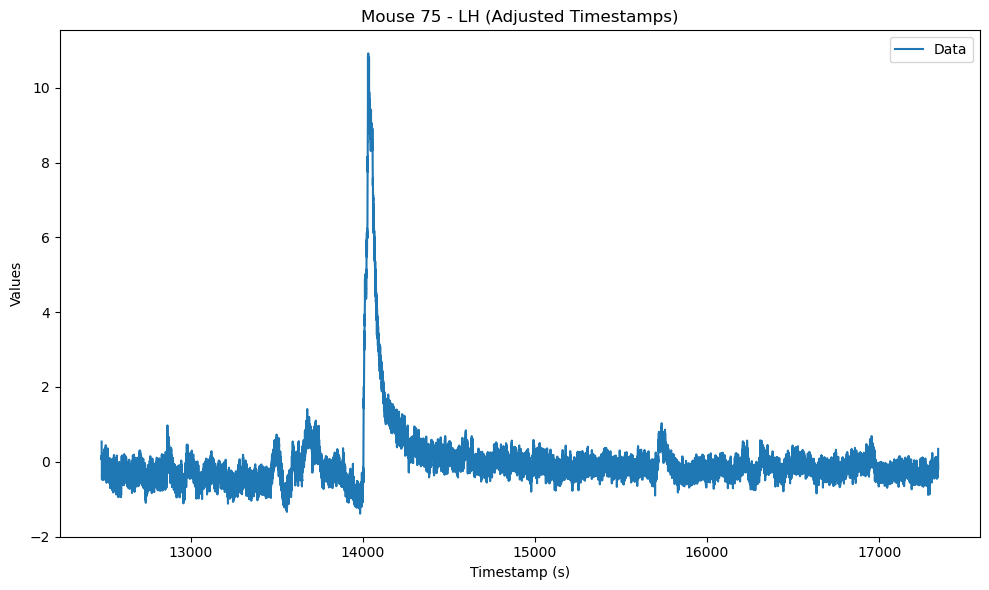

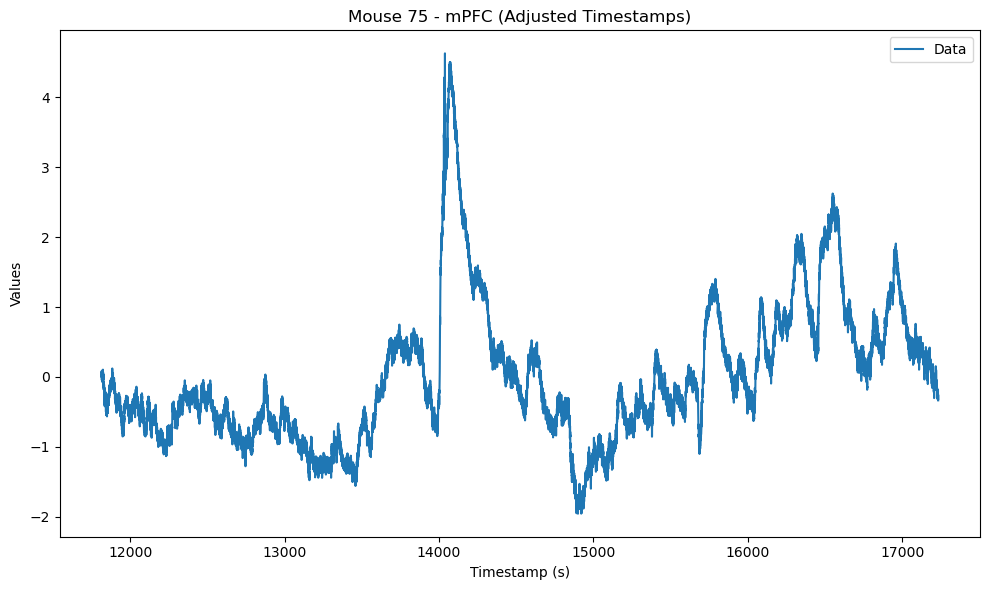

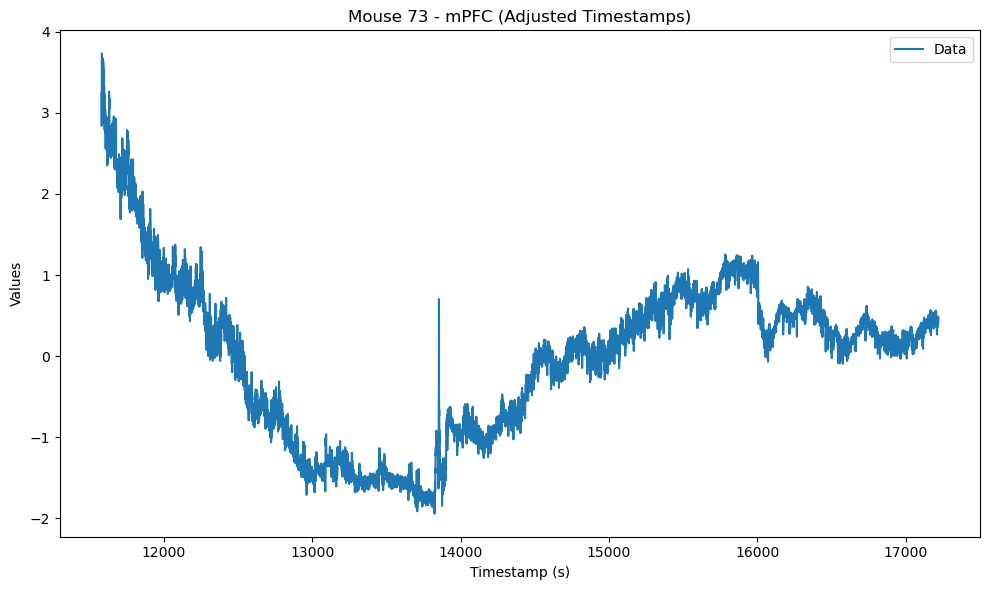

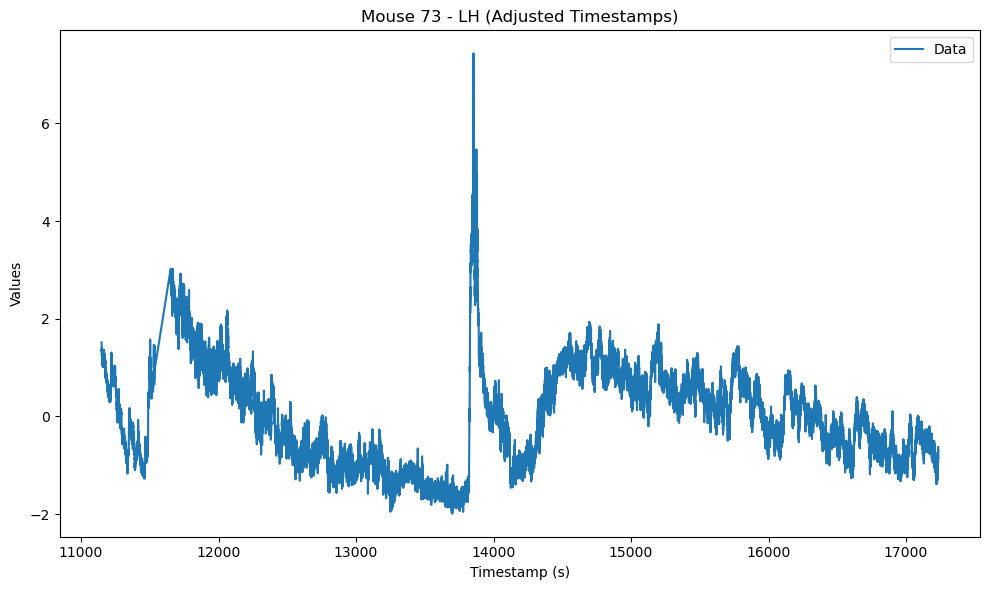

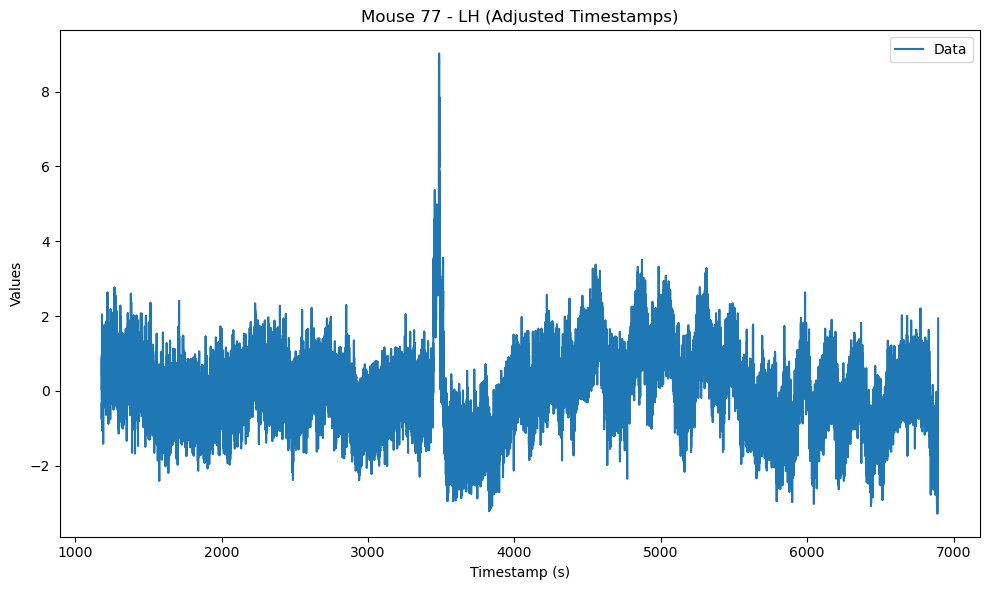

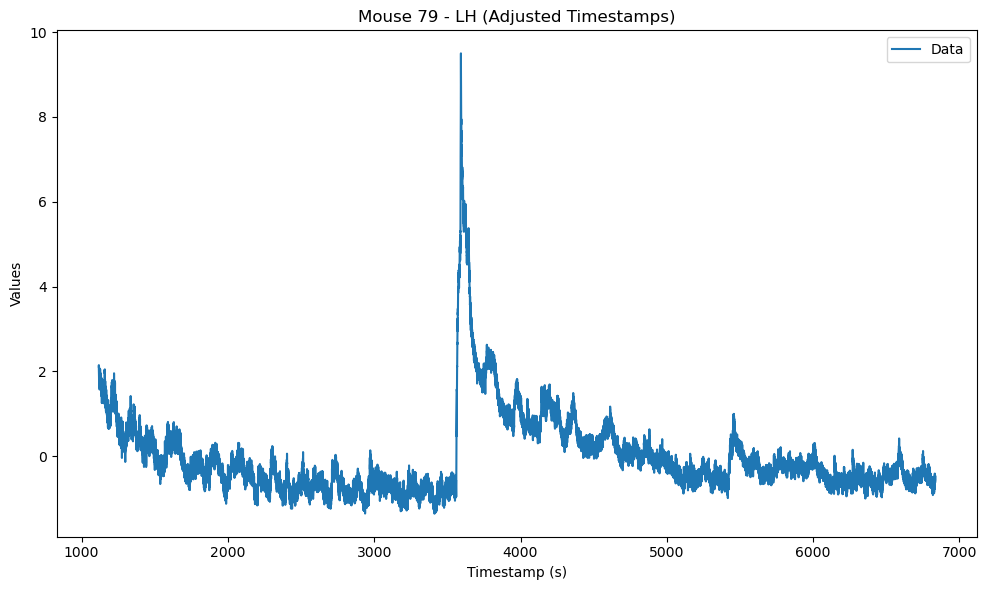

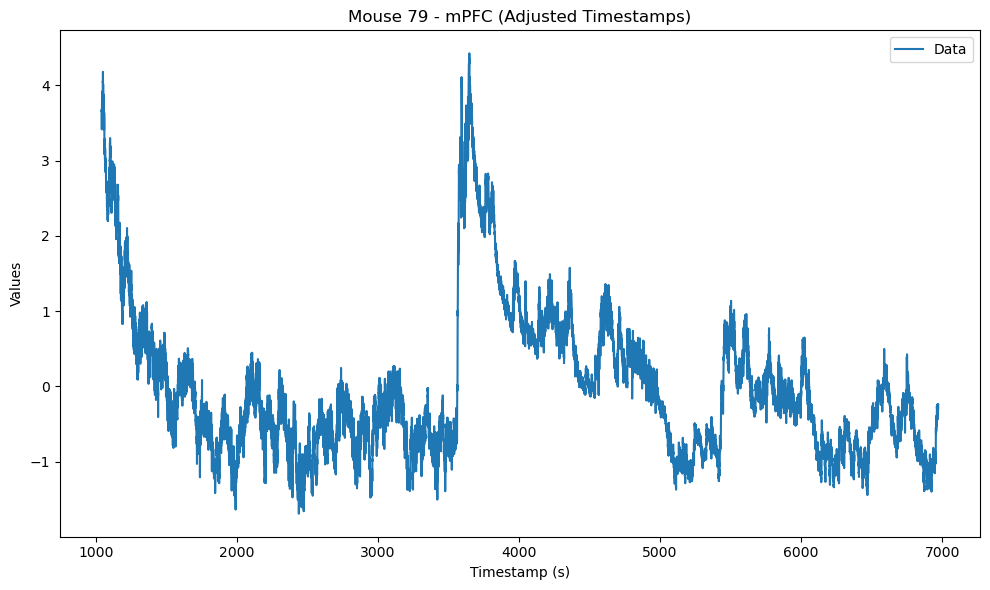

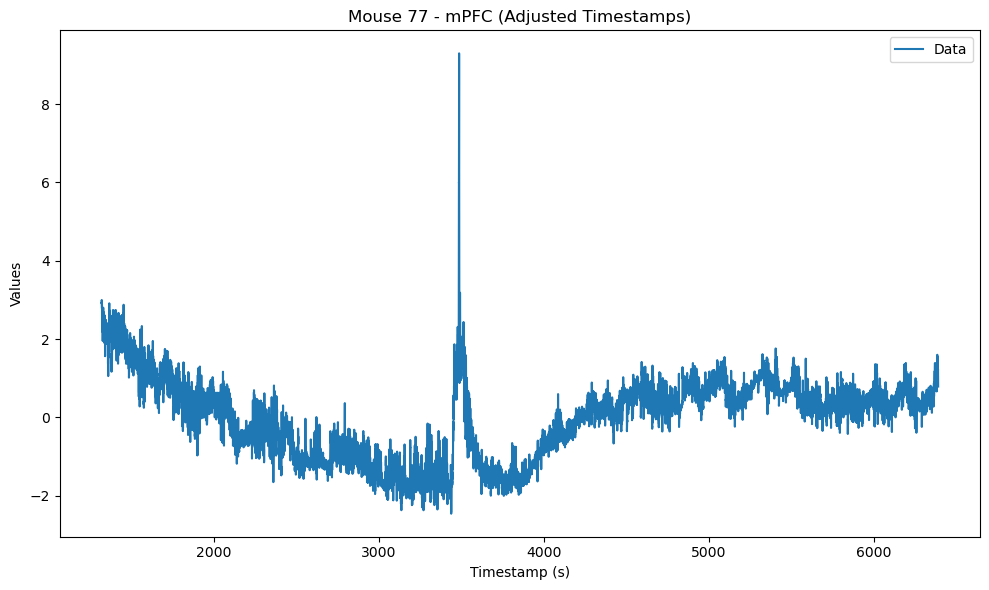

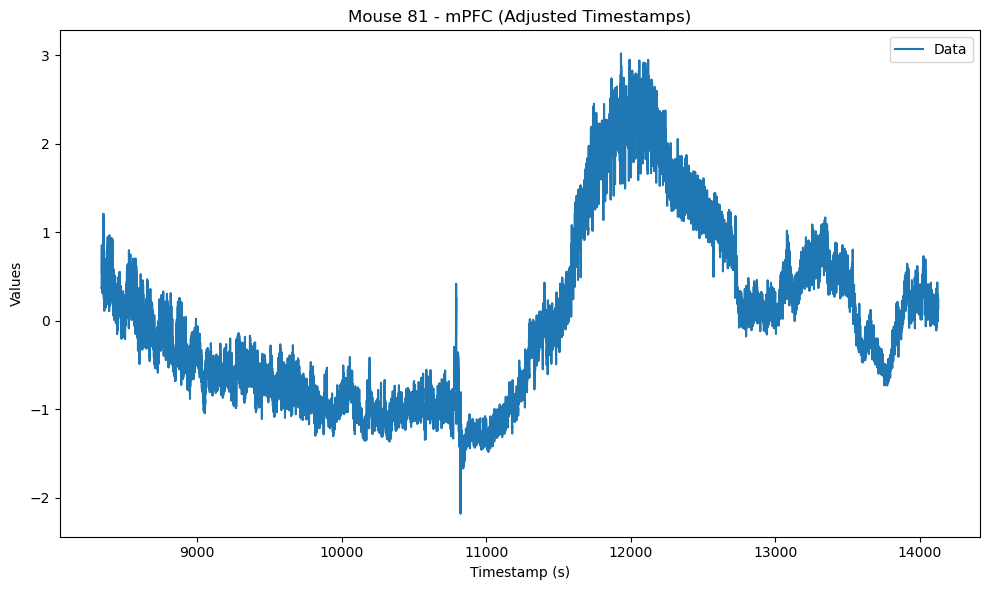

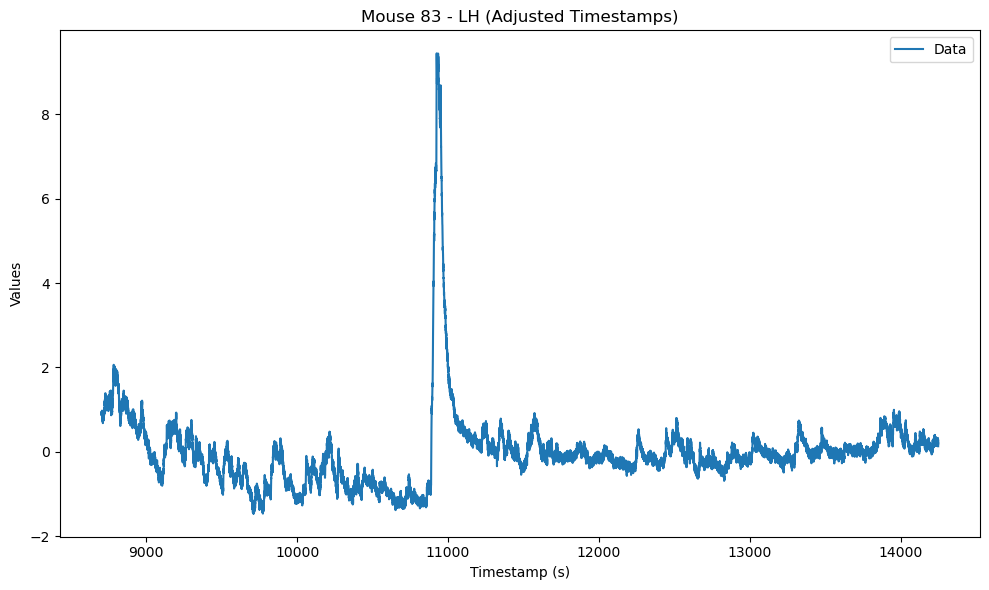

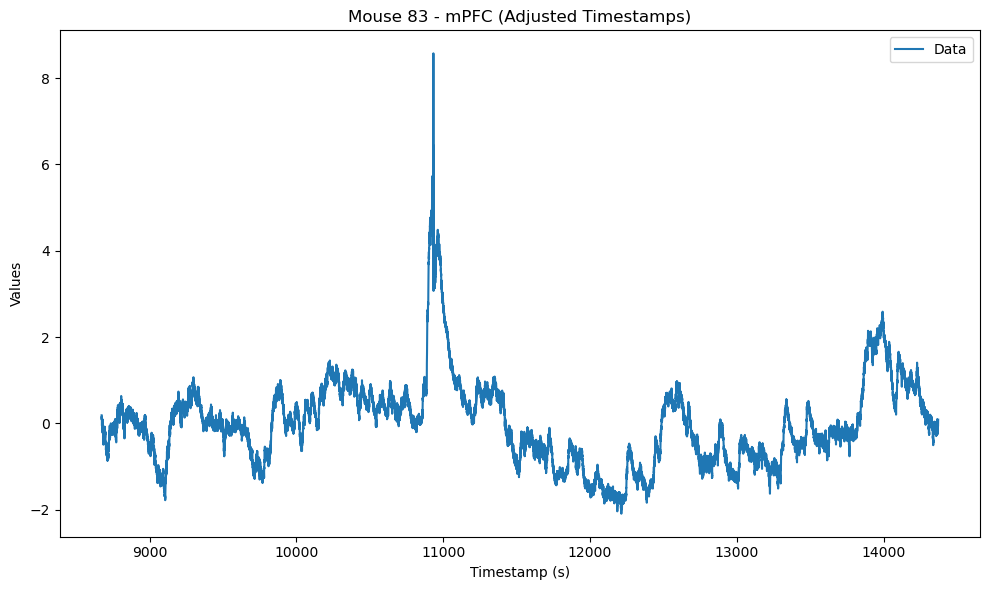

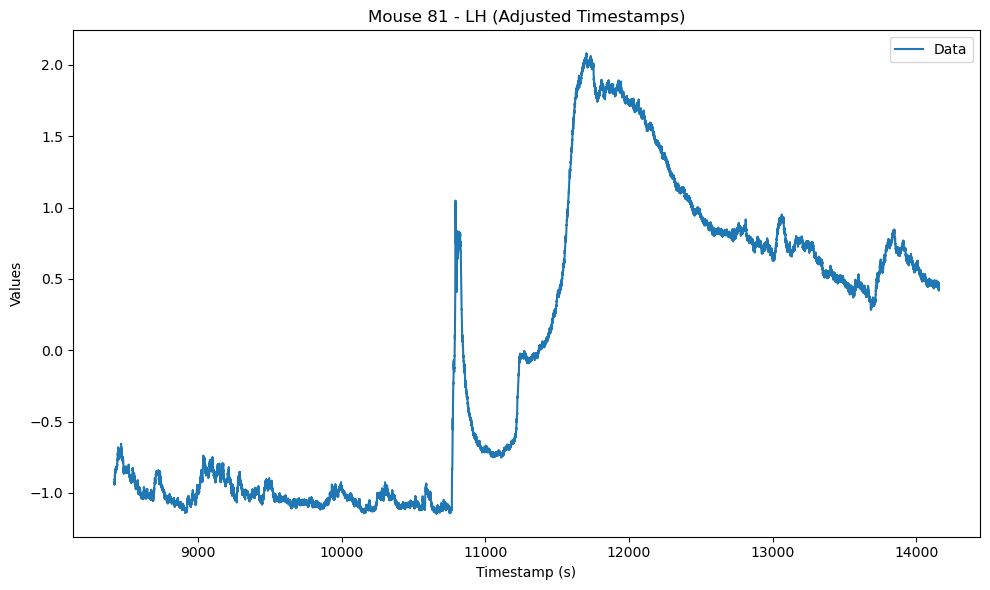

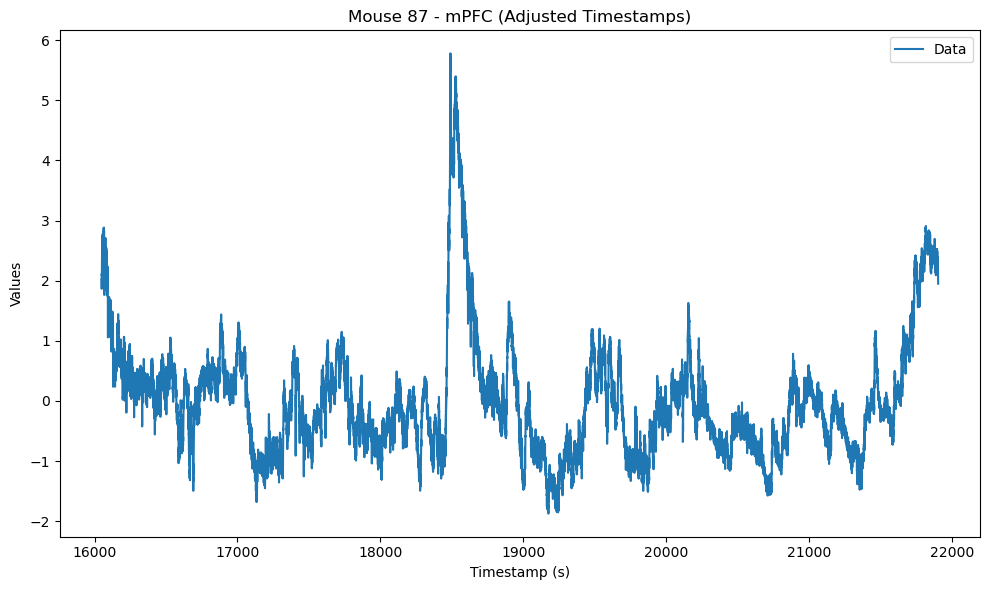

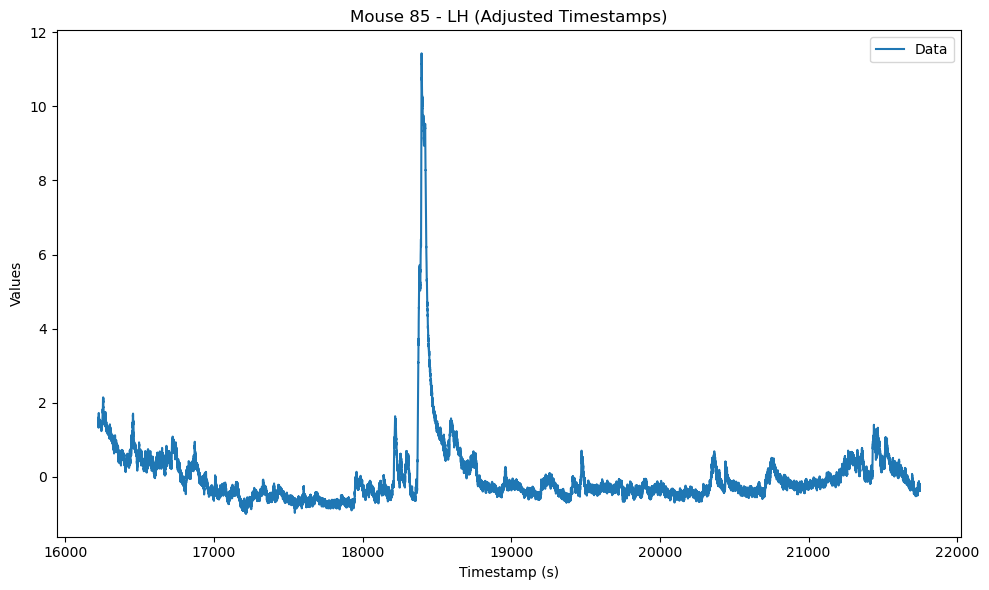

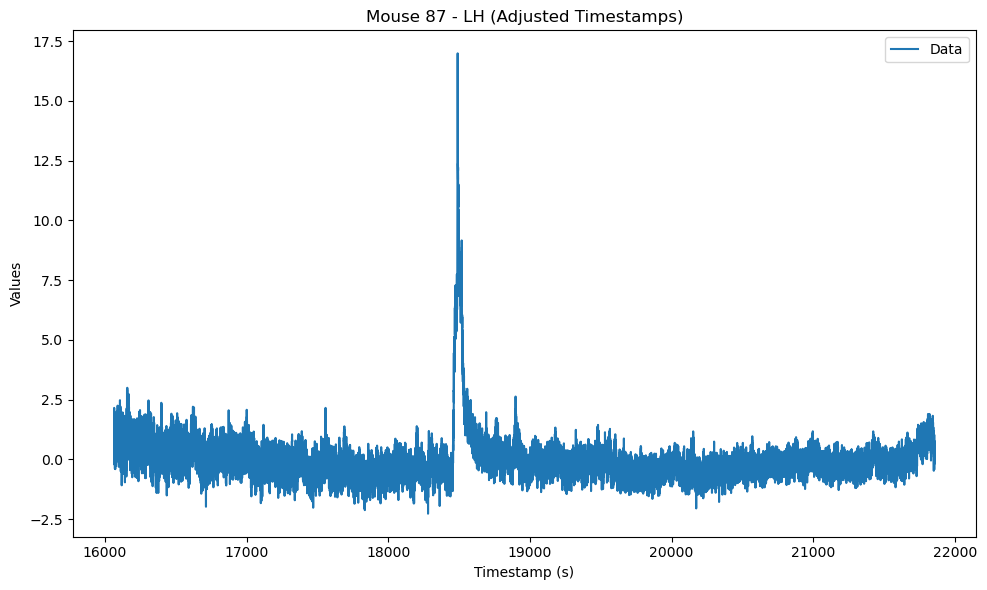

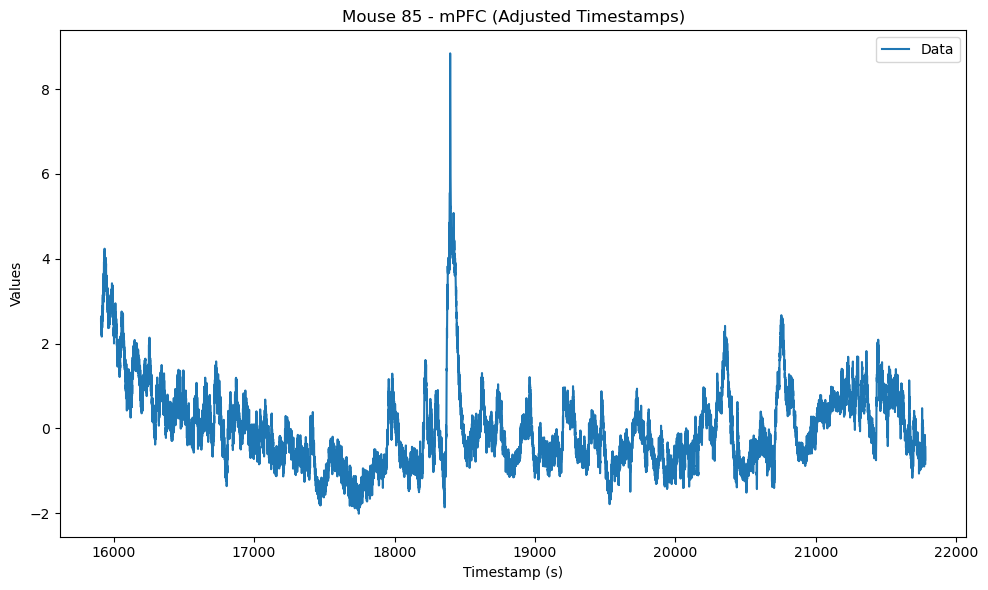

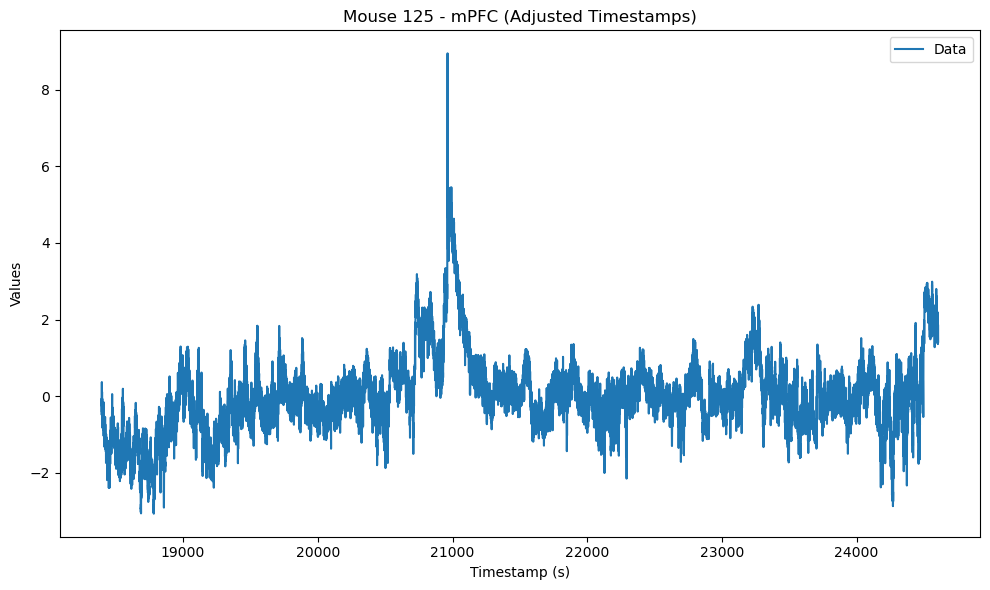

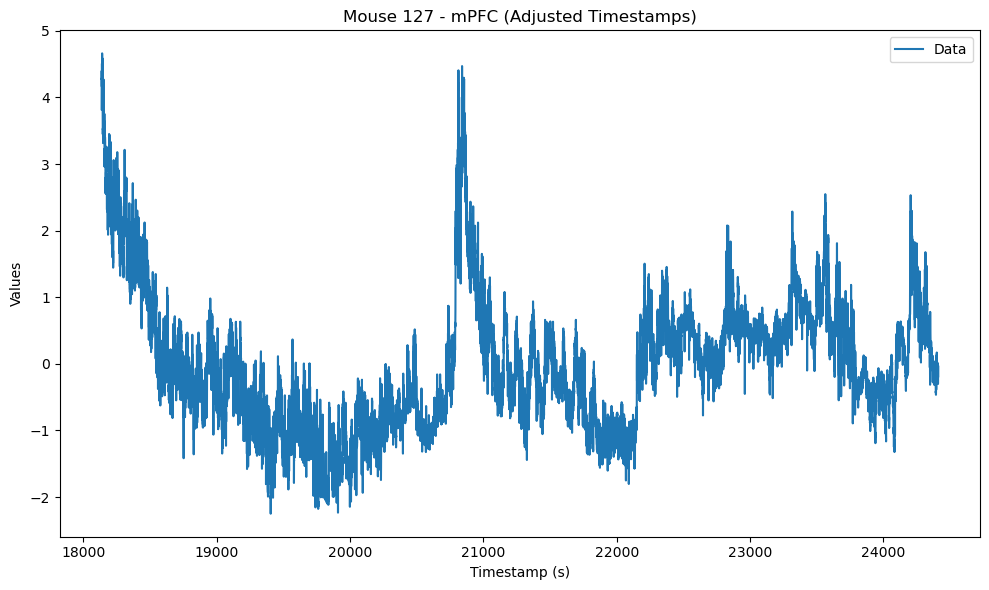

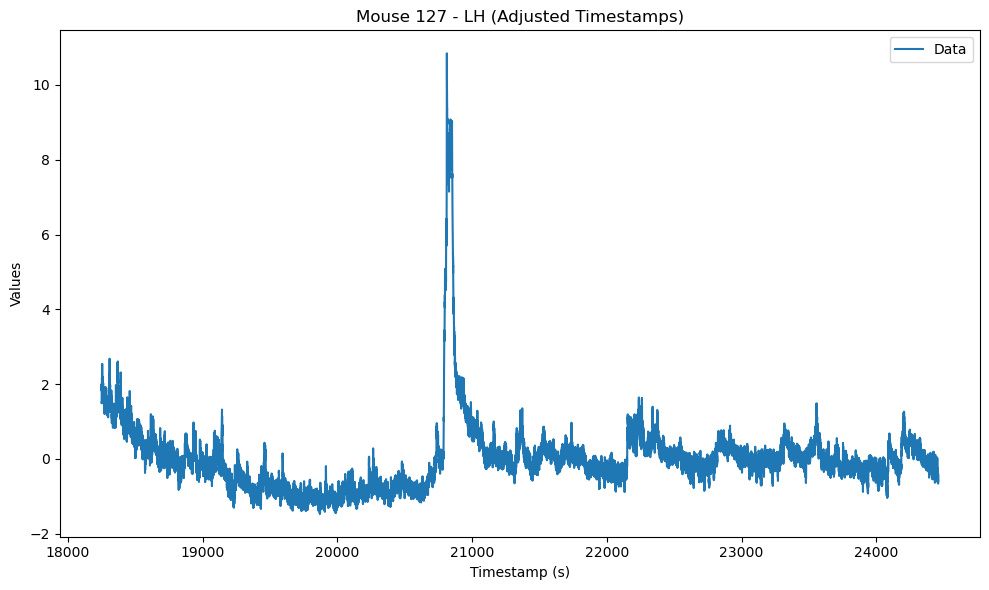

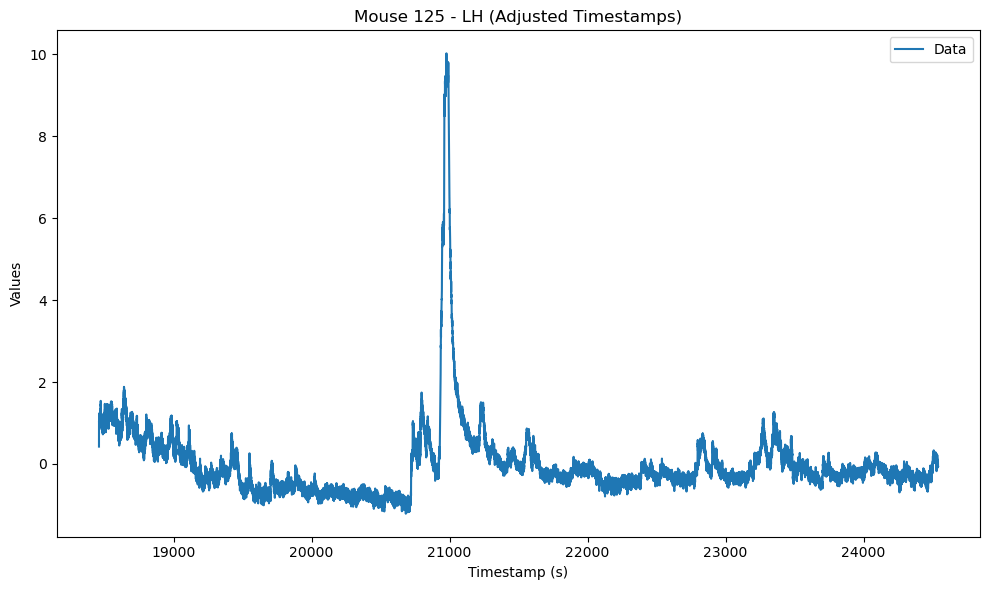

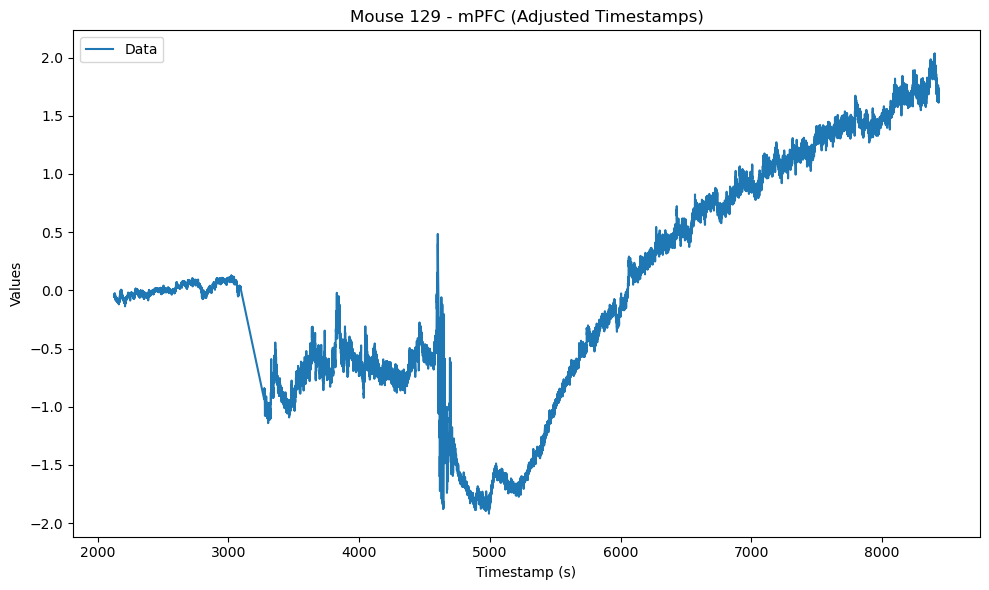

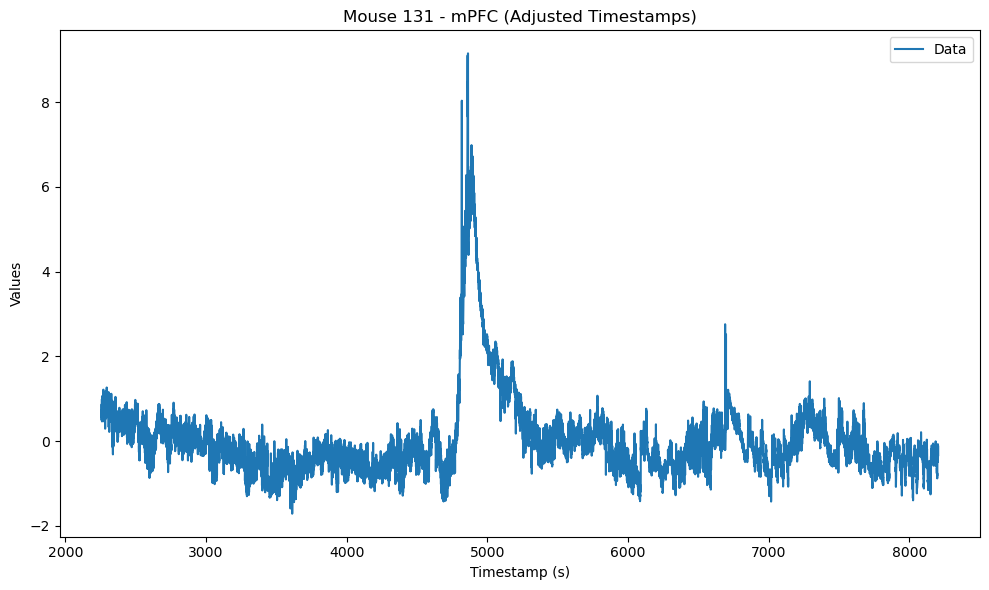

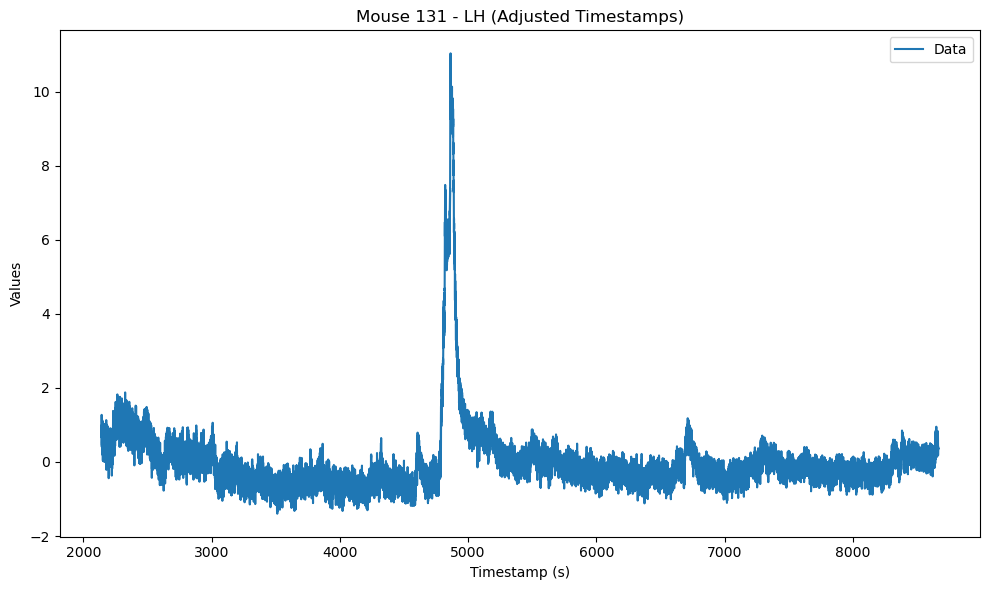

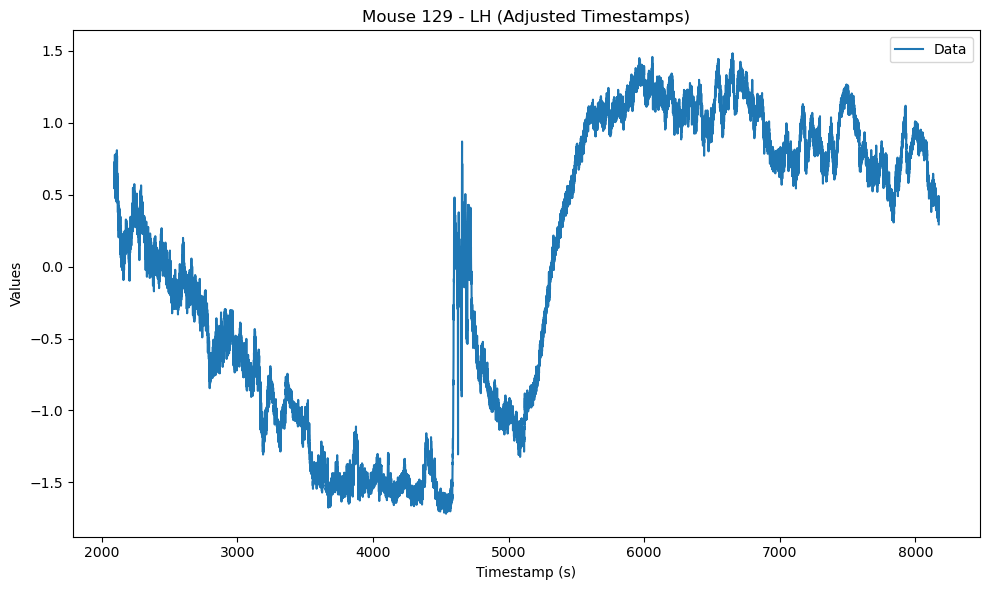

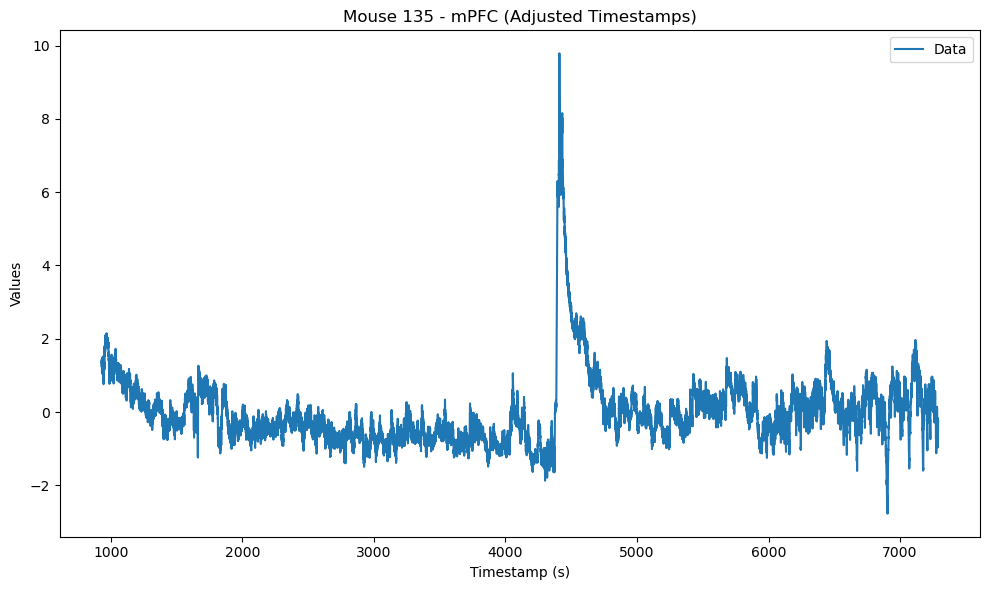

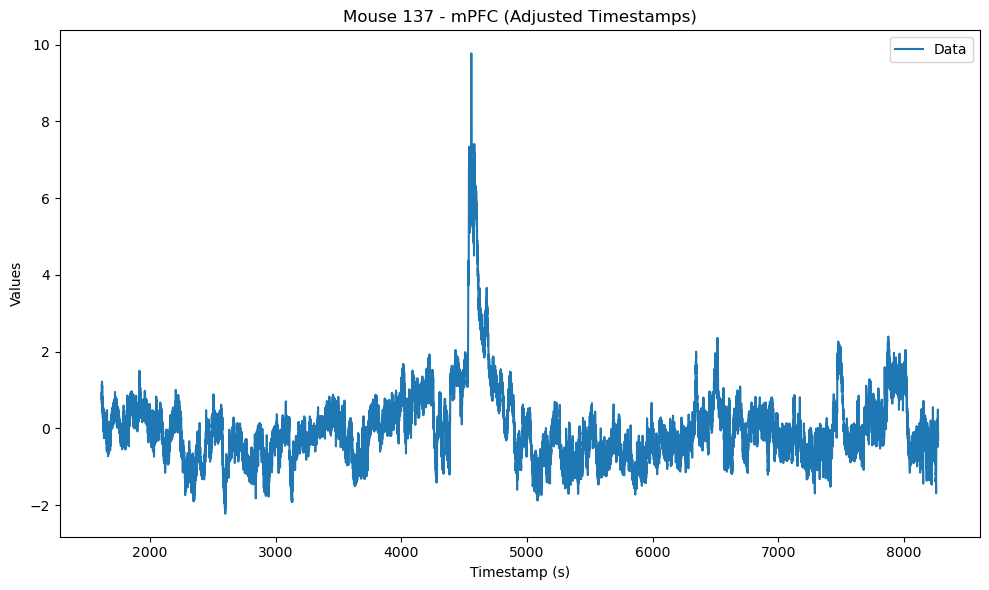

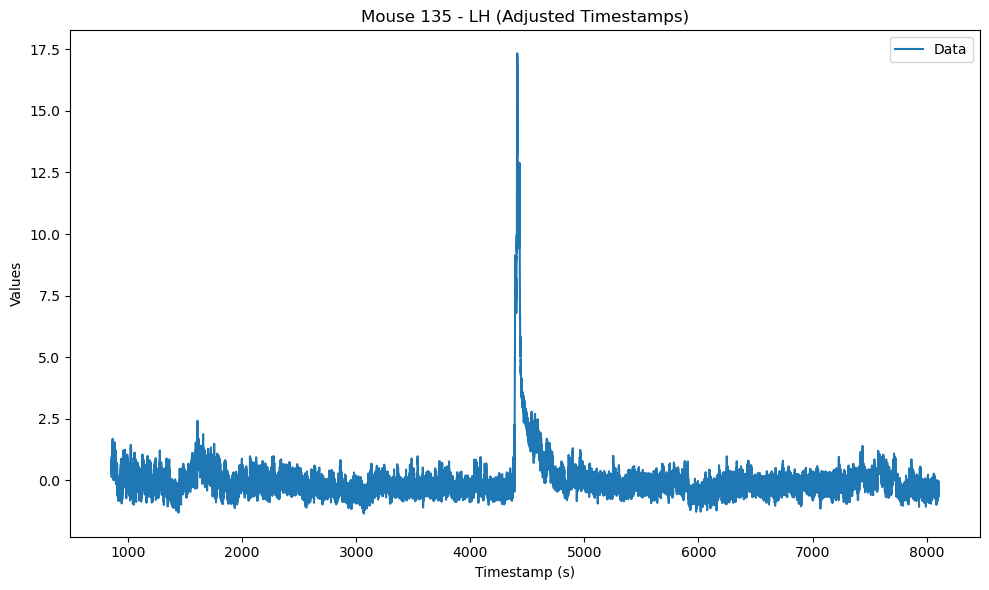

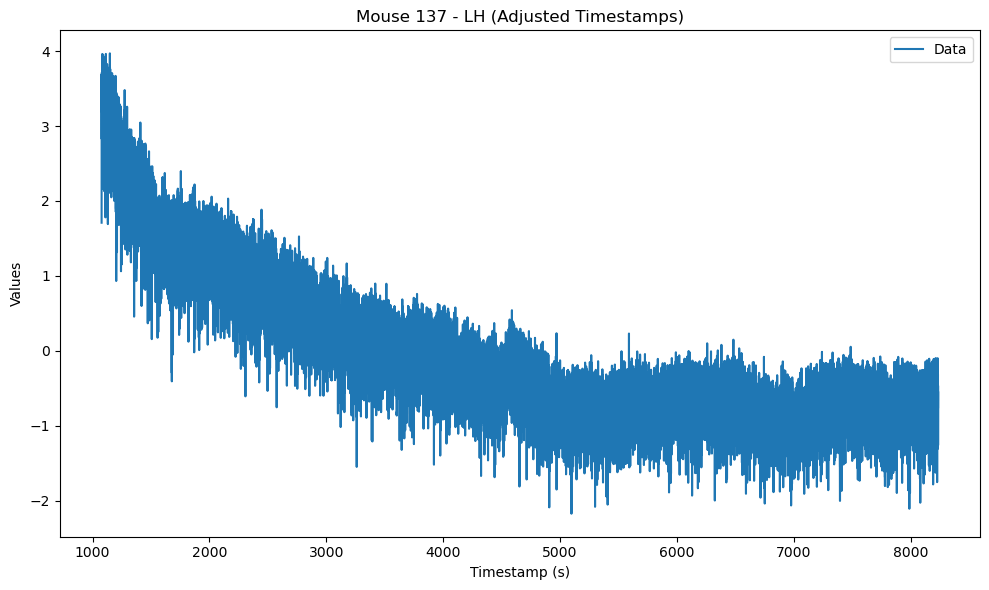

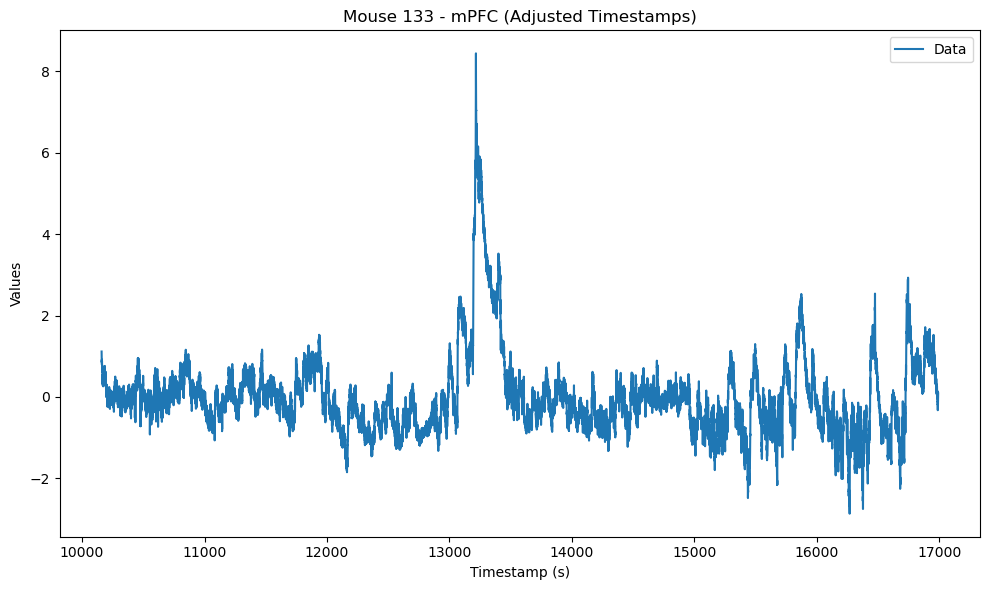

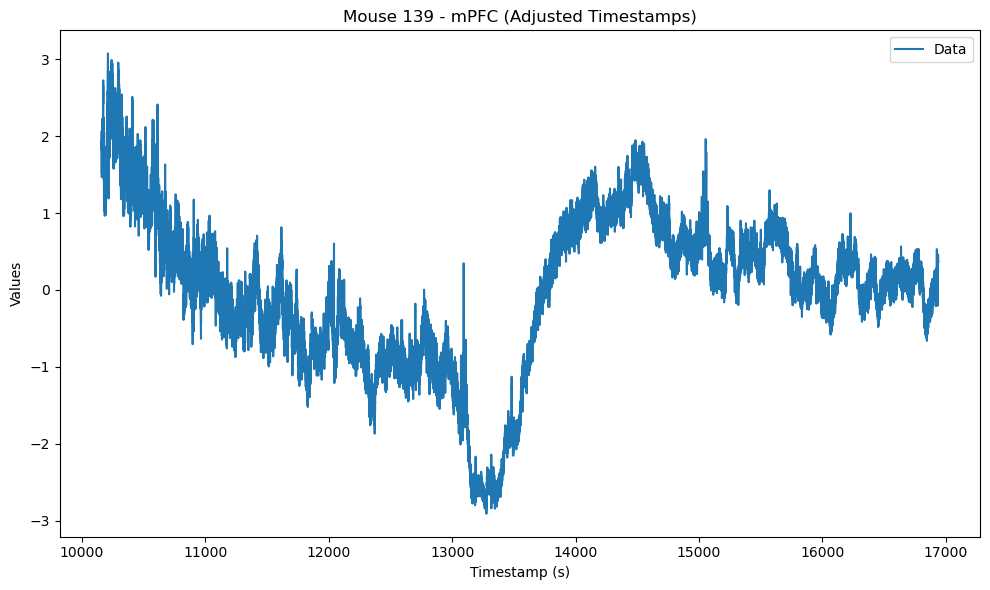

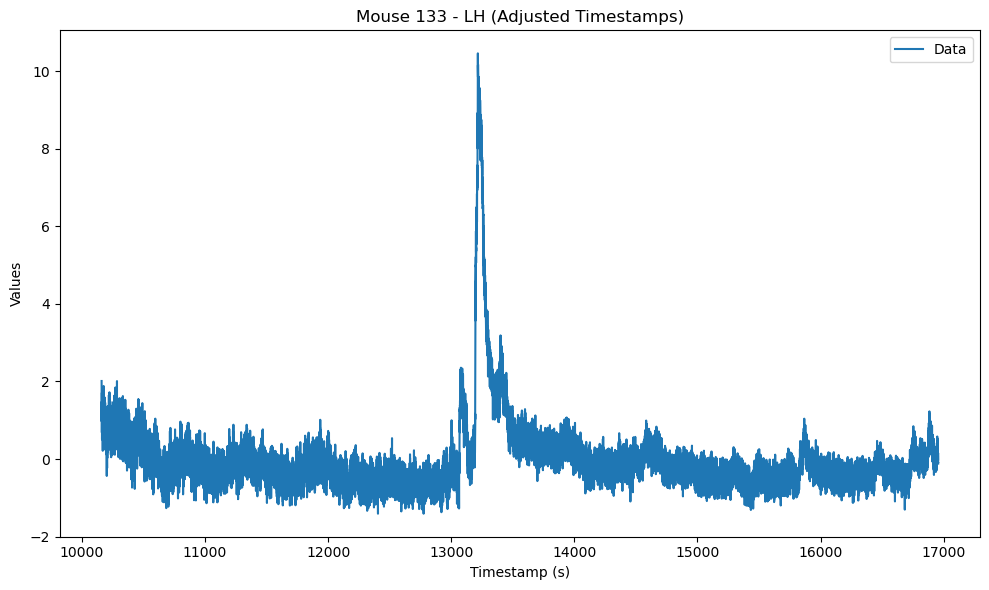

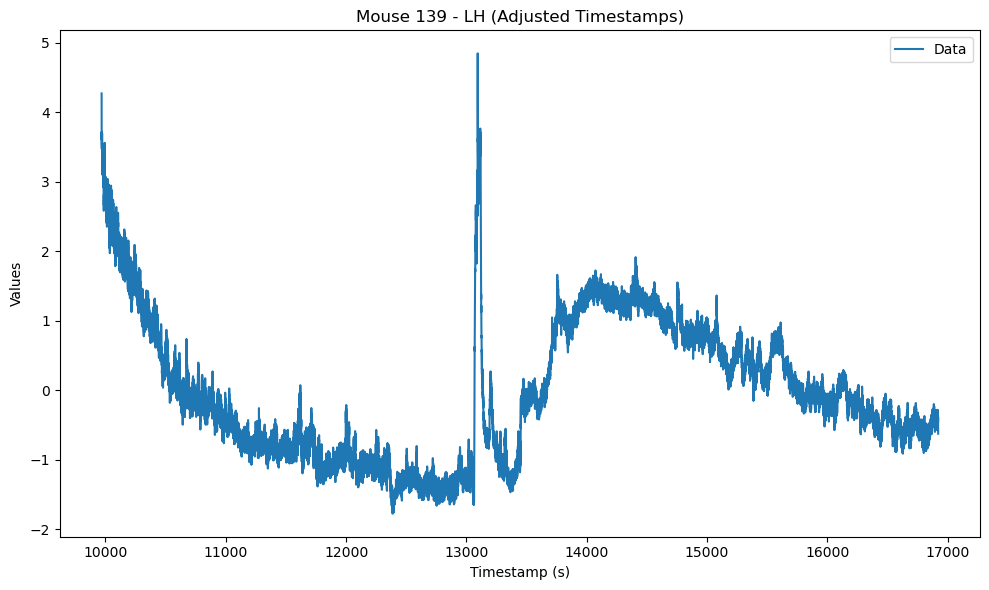

In [28]:
# Now plot with the adjusted DataFrames
for k, v in all_z_score_dfs.items():
    # Select the first `num_rows_to_plot` rows
    plt.figure(figsize=(10, 6))
    plt.title(f"Mouse {k[0]} - {k[1]} (Adjusted Timestamps)")
    
    # Plot each column, using different labels to identify the data
    plt.plot(v['timestamps'], v['data'], label='Data')
    
    # Additional plot formatting for readability
    plt.xlabel('Timestamp (s)')
    plt.ylabel('Values')
    plt.legend()
    plt.tight_layout()
    
    # Display the plot
    plt.show()